## Preprocess

In [1]:
import jsonlines
import pandas
import json
# Load the data from the JSON line file
with open('../data/python-public.jsonl', 'r') as f:
    dataframe = pandas.DataFrame([json.loads(line) for line in f])

In [2]:
import os
SEPARATOR_COMMENT = "\n/**<FIM>*/\n"
DATA_ROOT = "../data/repositories-python-public/"



def extract_original_code_from_row(row: pandas.Series) -> str:
    """
    Extract the original code from the file path.
    """
    repo_path = os.path.join(DATA_ROOT, "-".join([row["repo"].replace("/", "__"), row['revision']]))
    file_path = repo_path + "/" + row['path']
    with open(file_path, 'r') as file:
        content = file.read()
    return content

dataframe['original_code'] = dataframe.apply(extract_original_code_from_row, axis=1)
dataframe['incomplete_code'] = dataframe.apply(lambda row: SEPARATOR_COMMENT.join([row['prefix'], row['suffix']]), axis=1)


In [3]:
import diff_match_patch

def extract_diff_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the diff from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.diff_lineMode(original_code, incomplete_code, deadline=None)
    # Convert the diffs to a single diff string
    diffs = "\n".join([diff[1] for diff in diffs if diff[0] != 0])
    return diffs

def extract_patch_from_original_code_and_incomplete_code(row) -> str:
    """
    Extract the patch from the original code.
    """
    dmp = diff_match_patch.diff_match_patch()
    original_code = row['original_code']
    incomplete_code = row['incomplete_code']
    
    diffs = dmp.patch_make(original_code, incomplete_code)
    # Convert the patches to a single patch string
    patches = dmp.patch_toText(diffs)
    return patches




In [4]:
for index, row in dataframe.iterrows():
    output_root = "../samples-public/"  
    repo_revision = "-".join([row["repo"].replace("/", "__"), row['revision']])
    dir_name = os.path.join(output_root, repo_revision)
    os.makedirs(dir_name, exist_ok=True)
    original_file_path = os.path.join(dir_name, "original.py")
    incomplete_file_path = os.path.join(dir_name, "incomplete.py")
    diff_file_path = os.path.join(dir_name, "diff.diff")
    patch_file_path = os.path.join(dir_name, "patch.patch")
    
    
    with open(original_file_path, 'w') as original_file:
        original_file.write(row['original_code'])
    with open(incomplete_file_path, 'w') as incomplete_file:
        incomplete_file.write(row['incomplete_code'])
    with open(diff_file_path, 'w') as diff_file:
        diff_file.write(extract_diff_from_original_code_and_incomplete_code(row))
    with open(patch_file_path, 'w') as patch_file:
        patch_file.write(extract_patch_from_original_code_and_incomplete_code(row))
    
    dataframe.at[index, 'diff'] = extract_diff_from_original_code_and_incomplete_code(row)
    dataframe.at[index, 'patch'] = extract_patch_from_original_code_and_incomplete_code(row)

        


In [5]:

def extract_diff_prefix_and_suffix(row: pandas.Series) -> tuple[str, str]:
    """
    Extract the prefix and suffix from the diff.
    """
    diff = row['diff']
    splitted = diff.split(SEPARATOR_COMMENT)
    if len(splitted) < 2:
        return splitted[0], ""
    return splitted[0], splitted[1]

In [6]:
for index, row in dataframe.iterrows():
    output_root = "../samples-public/"  
    repo_revision = "-".join([row["repo"].replace("/", "__"), row['revision']])
    diff_prefix, diff_suffix = extract_diff_prefix_and_suffix(row)
    dataframe.at[index, 'diff_prefix'] = diff_prefix
    dataframe.at[index, 'diff_suffix'] = diff_suffix
    prefix, suffix = row['prefix'], row['suffix']
    with open(os.path.join(output_root, repo_revision, "diff_prefix.py"), 'w') as f:
        f.write(diff_prefix)
    with open(os.path.join(output_root, repo_revision, "diff_suffix.py"), 'w') as f:
        f.write(diff_suffix)
    with open(os.path.join(output_root, repo_revision, "prefix.py"), 'w') as f:
        f.write(prefix)
    with open(os.path.join(output_root, repo_revision, "suffix.py"), 'w') as f:
        f.write(suffix)

## Syntax tree analysis

In [7]:
# Let's create a simple example to demonstrate the tree-sitter query matching
import tree_sitter
from tree_sitter_languages import get_language
# Sample python code
python_code = """
import ABC
from xyz import some_function

def hello_world():
    print("Hello, World!")
class MyClass:
    def my_method(self):
        return "This is a method in MyClass"

"""

# Create a parser
parser = tree_sitter.Parser()
parser.set_language(get_language("python"))

# Parse the code
tree = parser.parse(bytes(python_code, "utf8"))

# Print the syntax tree
print(tree.root_node.sexp())

(module (import_statement name: (dotted_name (identifier))) (import_from_statement module_name: (dotted_name (identifier)) name: (dotted_name (identifier))) (function_definition name: (identifier) parameters: (parameters) body: (block (expression_statement (call function: (identifier) arguments: (argument_list (string (string_start) (string_content) (string_end))))))) (class_definition name: (identifier) body: (block (function_definition name: (identifier) parameters: (parameters (identifier)) body: (block (return_statement (string (string_start) (string_content) (string_end))))))))


## Token-level Analysis

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("JetBrains/Mellum-4b-sft-python")


/Users/minhna1112/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
print(tokenizer.encode(python_code))

[225, 653, 37278, 225, 1407, 30998, 1697, 1475, 89, 1465, 225, 225, 904, 23084, 89, 7321, 3161, 225, 247, 247, 247, 2136, 533, 10626, 38, 8098, 23889, 225, 925, 82888, 52, 225, 247, 247, 247, 1093, 1547, 89, 2376, 34, 983, 891, 225, 247, 247, 247, 247, 247, 247, 247, 545, 327, 2362, 432, 283, 1787, 351, 82888, 28, 225, 225]


In [10]:
def code_to_tokens(code: str | list[str]) -> list[int]:
    """
    Convert code to tokens using the tokenizer
    """
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    if isinstance(code, list):
        return [token for snippet in cleaned_code for token in tokenizer.encode(snippet)]
    return tokenizer.encode(cleaned_code)

dataframe['num_prefix_tokens'] = dataframe['prefix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_suffix_tokens'] = dataframe['suffix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_diff_tokens'] = dataframe['diff'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_prefix_tokens_in_diff'] = dataframe['diff_prefix'].apply(lambda x : len(code_to_tokens(x)))
dataframe['num_suffix_tokens_in_diff'] = dataframe['diff_suffix'].apply(lambda x : len(code_to_tokens(x)))

Text(0, 0.5, 'Frequency')

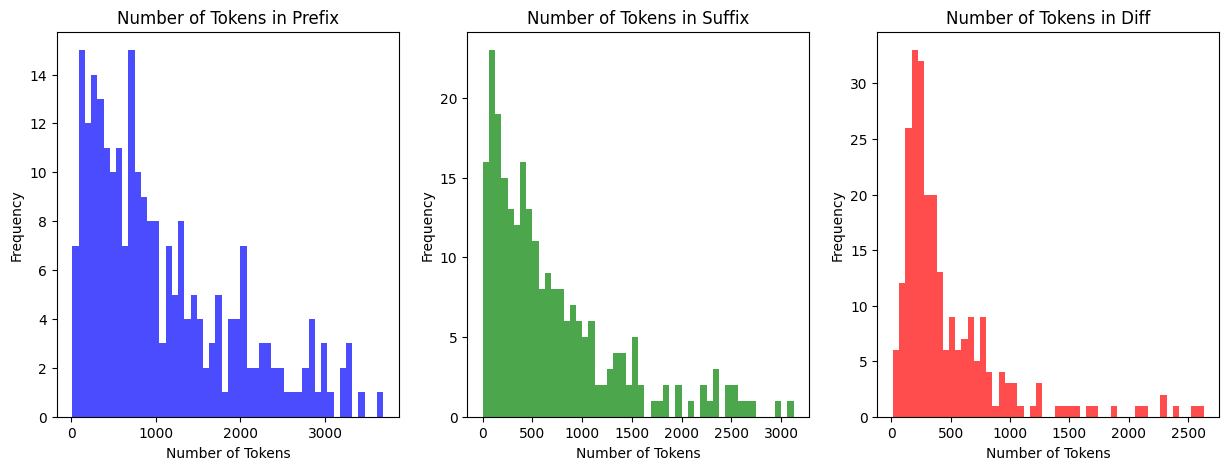

In [22]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

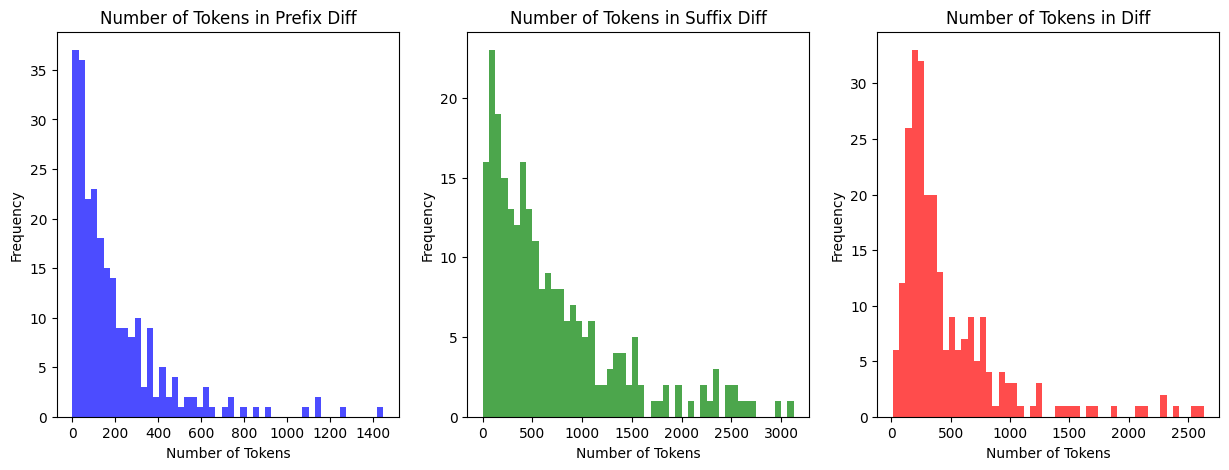

In [23]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens_in_diff'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

In [24]:
def remove_comments_nodes(code: str)->str:
    """
    Remove comments from the code using tree-sitter
    """
    language = get_language("python")
    parser = tree_sitter.Parser()
    parser.set_language(language)
    cleaned_code = code.replace(SEPARATOR_COMMENT, "")
    # Parse the code
    tree = parser.parse(bytes(cleaned_code, "utf8"))

    # Query to find comment nodes
    query_str = """
    (comment) @comment
    (expression_statement (string)) @comment
    """
    
    query = language.query(query_str)
    
    # Get matches
    matches = query.captures(tree.root_node)
    
    # Remove comment nodes from the code
    
    for match in matches:
        node = match[0]
        cleaned_code = cleaned_code[:node.start_byte] + cleaned_code[node.end_byte:]

    return cleaned_code

dataframe['prefix_without_comments'] = dataframe['prefix'].apply(
    remove_comments_nodes
)

dataframe['suffix_without_comments'] = dataframe['suffix'].apply(
    remove_comments_nodes
)
dataframe['diff_without_comments'] = dataframe['diff'].apply(
    remove_comments_nodes
)



Text(0.5, 1.0, 'Number of Tokens in Diff')

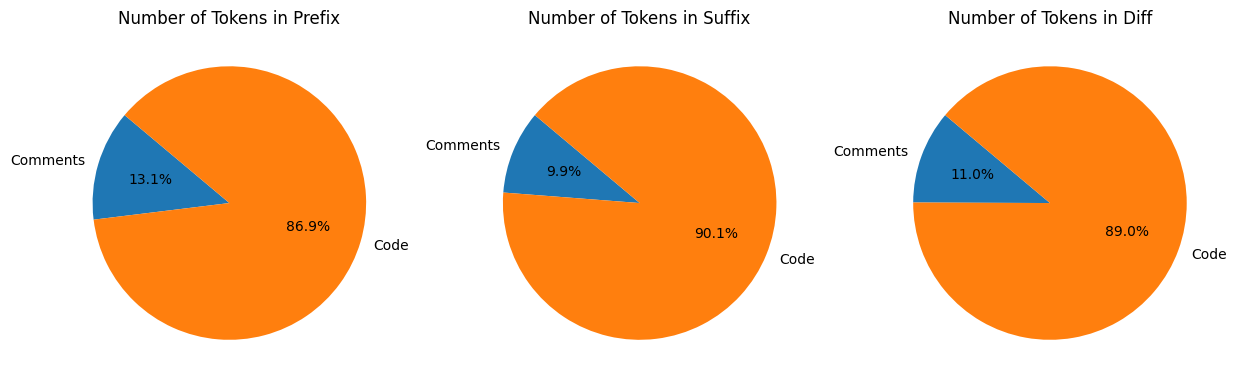

In [25]:
dataframe["num_prefix_tokens_without_comments"] = dataframe['prefix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_suffix_tokens_without_comments"] = dataframe['suffix_without_comments'].apply(lambda x : len(code_to_tokens(x)))
dataframe["num_diff_tokens_without_comments"] = dataframe['diff_without_comments'].apply(lambda x : len(code_to_tokens(x)))

# plot 3 pie charts of the number of tokens  between code and comments (original - code) in prefix, suffix, and diff

import matplotlib.pyplot as plt

labels = ['Comments', 'Code']
prefix_sizes = [
    dataframe['num_prefix_tokens'].sum() - dataframe['num_prefix_tokens_without_comments'].sum(),
    dataframe['num_prefix_tokens_without_comments'].sum()
]
suffix_sizes = [
    dataframe['num_suffix_tokens'].sum() - dataframe['num_suffix_tokens_without_comments'].sum(),
    dataframe['num_suffix_tokens_without_comments'].sum()
]
diff_sizes = [
    dataframe['num_diff_tokens'].sum() - dataframe['num_diff_tokens_without_comments'].sum(),
    dataframe['num_diff_tokens_without_comments'].sum()
]
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.pie(prefix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Prefix')
plt.subplot(1, 3, 2)
plt.pie(suffix_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Suffix')
plt.subplot(1, 3, 3)
plt.pie(diff_sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Number of Tokens in Diff')


Text(0, 0.5, 'Frequency')

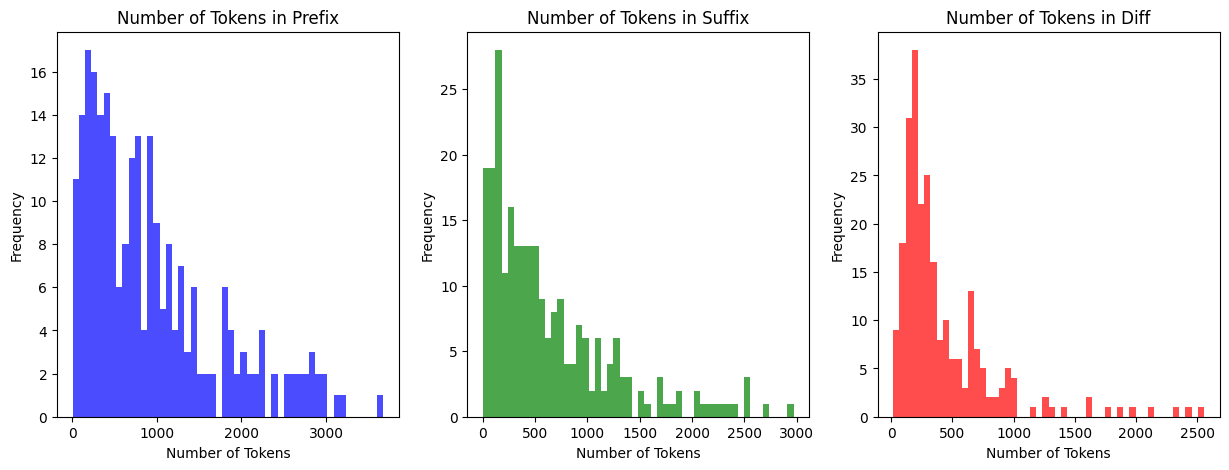

In [26]:
# plot 3 histograms of the number of tokens in prefix, suffix, and diff (after removing comments)
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(dataframe['num_prefix_tokens_without_comments'], bins=50, color='blue', alpha=0.7)
plt.title('Number of Tokens in Prefix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(dataframe['num_suffix_tokens_without_comments'], bins=50, color='green', alpha=0.7)
plt.title('Number of Tokens in Suffix')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(dataframe['num_diff_tokens_without_comments'], bins=50, color='red', alpha=0.7)
plt.title('Number of Tokens in Diff')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

### Localize Completion Point

In [40]:
from tree_sitter import Node
from tree_sitter_languages import get_language, get_parser
# using tree-sitter to find multi-line comment nodes in the diff
import re
import pandas
SEPARATOR_COMMENT = "\n/**<FIM>*/\n"
def detect_completion_point(row) -> tuple[int, int]:
    """
    Detect the completion point by taking the end point of the prefix.
    """
    parser = get_parser("python")
    tree = parser.parse(bytes(row["prefix"], "utf8"))
    # Find the end point of the prefix
    if not tree.root_node.children:
        return tree.root_node.end_point
    
    # The completion point is the end point of the last child node
    last_child = tree.root_node.children[-1]
    return last_child.end_point 

def detect_completion_point_in_diff(row: pandas.Series) -> tuple[int, int]:
    """
    Detect the completion point in the diff by taking the end point of the prefix.
    """
    parser = get_parser("python")
    tree = parser.parse(bytes(row["diff_prefix"], "utf8"))

    # Find the end point of the prefix
    if not tree.root_node.children:
        return tree.root_node.end_point
    
    # The completion point is the end point of the last child node
    last_child = tree.root_node.children[-1]
    return last_child.end_point 

def localize_outer_symbol_from_completion_point(row: pandas.Series) -> tuple[Node, str]:
    """
    Find the innermost symbol declaration that contains the completion point.
    """
    parser = get_parser("python")
    incomplete_code = row["incomplete_code"].replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(incomplete_code, "utf8"))
    
    with open("../python_functions.scm", "r") as f:
        query_str = f.read()
    query = get_language("python").query(query_str)

    matches = query.captures(tree.root_node)
    declarations = [(node, node_type) for node, node_type in matches if "declaration" in node_type]
    
    completion_point = detect_completion_point(row)
    
    # Find all declarations that contain the completion point
    containing_declarations = []
    for node, node_type in declarations:
        if (node.start_point <= completion_point <= node.end_point):
            # print(f"Node: {node.text.decode('utf-8')}, Type: {node_type}, Start: {node.start_point}, End: {node.end_point}, Completion Point: {completion_point}")
            containing_declarations.append((node, node_type))
    
    if not containing_declarations:
        # get neighbor (sibiling of the closest parent) nodes
        
        return None, None
    
    # Return the innermost (latest starting) declaration
    return max(containing_declarations, key=lambda x: x[0].start_point)


def localize_outer_symbol_from_completion_point_in_diff(row: pandas.Series) -> tuple[Node, str]:
    """
    Find the innermost symbol declaration that contains the completion point.
    """
    parser = get_parser("python")
    incomplete_code = row["diff"].replace(SEPARATOR_COMMENT, "")
    tree = parser.parse(bytes(incomplete_code, "utf8"))
    
    with open("../python_functions.scm", "r") as f:
        query_str = f.read()
    query = get_language("python").query(query_str)

    matches = query.captures(tree.root_node)
    declarations = [(node, node_type) for node, node_type in matches if "declaration" in node_type]

    completion_point = detect_completion_point_in_diff(row)

    # Find all declarations that contain the completion point
    containing_declarations = []
    for node, node_type in declarations:
        if (node.start_point <= completion_point <= node.end_point):
            # print(f"Node: {node.text.decode('utf-8')}, Type: {node_type}, Start: {node.start_point}, End: {node.end_point}, Completion Point: {completion_point}")
            containing_declarations.append((node, node_type))
    
    if not containing_declarations:
        # get neighbor (sibiling of the closest parent) nodes
        
        return None, None
    
    # Return the innermost (latest starting) declaration
    return max(containing_declarations, key=lambda x: x[0].start_point)

In [41]:
dataframe['completion_point'] = dataframe.apply(detect_completion_point, axis=1)
dataframe['completion_point_in_diff'] = dataframe.apply(detect_completion_point_in_diff, axis=1)

In [42]:
dataframe['num_diff_tokens'].median()

np.float64(311.0)

### Zoekt


In [43]:
import requests
import json

url = "http://localhost:6070/api/search"

payload = json.dumps({
  "Q": "force_shutdown force restart r:amnweb__yasb-",
  "Opts": {
    "NumContextLines": 5,
    "MaxResults": 10,
  }
})
headers = {
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

print(response.text)


{"Result":{"ContentBytesLoaded":110344,"IndexBytesLoaded":6819,"Crashes":0,"Duration":12885916,"FileCount":17,"ShardFilesConsidered":0,"FilesConsidered":17,"FilesLoaded":17,"FilesSkipped":0,"ShardsScanned":5,"ShardsSkipped":0,"ShardsSkippedFilter":0,"MatchCount":66,"NgramMatches":129,"NgramLookups":1210,"Wait":39792,"MatchTreeConstruction":26167833,"MatchTreeSearch":6476376,"RegexpsConsidered":0,"FlushReason":0,"Files":[{"FileName":"src/core/utils/win32/power.py","Repository":"amnweb__yasb-86a5126b7500e73d31a2f1b4618a53ba3bd4c148","Language":"Python","LineMatches":[{"Line":"ICAgIGRlZiByZXN0YXJ0KHNlbGYpOgo=","LineStart":1295,"LineEnd":1318,"LineNumber":35,"Before":"ICAgICAgICAgICAgd2luMzJzZWN1cml0eS5BZGp1c3RUb2tlblByaXZpbGVnZXMoaHRva2VuLCAwLAogICAgICAgICAgICAgICAgWyhwcml2X2lkLCB3aW4zMnNlY3VyaXR5LlNFX1BSSVZJTEVHRV9FTkFCTEVEKV0pCiAgICAgICAgICAgIGN0eXBlcy53aW5kbGwucG93cnByb2YuU2V0U3VzcGVuZFN0YXRlKEZhbHNlLCBUcnVlLCBGYWxzZSkKICAgICAgICAgICAgd2luMzJhcGkuQ2xvc2VIYW5kbGUoaHRva2VuKQoK","After":"

In [44]:
import json

searched_files = json.loads(response.text)['Result']['Files']

In [45]:
import base64

def decode_line(line: str) -> str:
    """
    Decode a base64 encoded line.
    """
    return base64.b64decode(line).decode('utf-8')

matches = searched_files[0]['LineMatches']
# matches.sort(key=lambda x: x['LineNumber'])
code_snippets = ["".join([decode_line(match['Before']), decode_line(match['Line']), decode_line(match['After'])]) for match in matches]

In [46]:
code_snippets

['            win32security.AdjustTokenPrivileges(htoken, 0,\n                [(priv_id, win32security.SE_PRIVILEGE_ENABLED)])\n            ctypes.windll.powrprof.SetSuspendState(False, True, False)\n            win32api.CloseHandle(htoken)\n\n    def restart(self):\n        self.main_window.hide()\n        self.overlay.hide()\n        QCoreApplication.exit(0)\n        subprocess.Popen("shutdown /r /t 0", stdout=subprocess.PIPE, stderr=subprocess.DEVNULL, shell=True)\n\n',
 '        self.main_window.hide()\n        self.overlay.hide()\n        QCoreApplication.exit(0)\n        subprocess.Popen("shutdown /s /hybrid /t 0", stdout=subprocess.PIPE, stderr=subprocess.DEVNULL, shell=True)\n\n    def force_shutdown(self):\n        self.main_window.hide()\n        self.overlay.hide()\n        QCoreApplication.exit(0)\n        subprocess.Popen("shutdown /s /f /t 0", stdout=subprocess.PIPE, stderr=subprocess.DEVNULL, shell=True)\n\n',
 '        self.main_window.hide()\n        self.overlay.hide(

In [47]:
from typing import List, Tuple
from pydantic import BaseModel
from typing_extensions import Literal
class ContextConfig(BaseModel):
    # zoekt query
    query_reference: Literal['diff', 'diff_prefix', 'diff_suffix', 'diff_prefix_and_suffix', 'container_symbol'] = 'diff'
    max_terms: int = 6
    use_temporal_context: bool = True
    keep_original_navigation: bool = True
    case_sensitive: bool = True
    use_or_logic: bool = False
    identifiers_extraction_strategy: Literal['functions_and_classes', 'navigation_expression', 'all_identifiers'] = 'functions_and_classes'
    
    
    # prefix and suffix
    use_whole_prefix: bool = False
    use_whole_suffix: bool = False
    use_diff_prefix: bool = True
    use_diff_suffix: bool = True
    
    # Token numbers
    max_tokens: int = 8192
    max_reserved_tokens: int = dataframe['num_diff_tokens'].median()  # Use median number of tokens in diff as a default
    # number of results file
    top_k_file: int = 3


def process_navigation_expression(s: str, case_sensitive: bool) -> str:
    s =  "".join(c if c.isalnum() else " " for c in s)
    s = ".".join(s.strip().replace("\n", " ").replace("  ", " ").split())    
    s = s.lower() if not case_sensitive else s
    return s

def process_navigation_expressions(navigation_expressions: List[str], case_sensitive: bool) -> List[str]:
    navigation_expressions = list(set(navigation_expressions))  # Remove duplicates
    return [process_navigation_expression(expr, case_sensitive) for expr in navigation_expressions]

def filter_and_rank_identifiers(identifiers: List[str], maximum_terms: int) -> List[str]:
     # rank identifiers by their frequency in the code snippet
    identifier_counts = {identifier: identifiers.count(identifier) for identifier in identifiers}
    identifiers = sorted(identifiers, key=lambda x: identifier_counts[x], reverse=True)
    identifiers = list(set(identifiers))
    # Limit to maximum_terms
    return identifiers[:maximum_terms]

def get_all_function_and_class_names(code_snippet: str) -> Tuple[List[str], List[int]]:
    """
    Extract all function and class names from a code snippet.
    """
    language = get_language("python")
    ts_query = """"""
    with open("../python_symbols_identifiers.scm", "r") as f:
        ts_query = f.read()
    parser = get_parser("python")
    tree = parser.parse(bytes(code_snippet, "utf8"))
    
    function_and_class_names = []
    start_lines = []
    for match in language.query(ts_query).captures(tree.root_node):
        function_and_class_names.append(match[0].text.decode('utf-8'))
        start_lines.append(match[0].start_point[0]) 
    return function_and_class_names, start_lines

def construct_query_from_code_snippet(code_snippet: str | dict, 
                                      repo_name: str, 
                                      config: ContextConfig,
                                      completion_line: int = 0) -> Tuple[str, str]:
    """
    Construct a query from a code snippet using the provided configuration.
    
    Args:
        code_snippet: The code snippet to analyze
        repo_name: Repository name for the query
        config: ContextConfig object containing all configuration parameters
        completion_line: Line number of the completion point
    
    Returns:
        Tuple of (query_string, strategy_used)
    """
    function_and_class_names = []
    navigation_expressions = []
    wild_identifiers = []
    strategy_used = None
    
    # Determine extraction strategy based on config
    if config.identifiers_extraction_strategy == 'functions_and_classes':
        # Get all function and class names
        function_and_class_names = []
        if isinstance(code_snippet, dict):
            start_lines = []
            for snippet_type, snippet in code_snippet.items():
                
                function_and_class_names_piece, start_lines_piece = get_all_function_and_class_names(snippet)
                function_and_class_names.extend(function_and_class_names_piece)
                if start_lines_piece and snippet_type == 'diff_suffix':
                    start_lines_piece = [line + completion_line for line in start_lines_piece]
                start_lines.extend(start_lines_piece)
        else:
            function_and_class_names, start_lines = get_all_function_and_class_names(code_snippet)
        
        if function_and_class_names:
            strategy_used = 'functions_and_classes'
            print(f"Found {len(function_and_class_names)} function and class names: {function_and_class_names}")
            # Sort by distance to the predefined line number (completion_line)
            function_and_class_names_with_distance = list(zip(function_and_class_names, start_lines))
            function_and_class_names_with_distance.sort(key=lambda x: abs(x[1] - completion_line))
            function_and_class_names = [name for name, _ in function_and_class_names_with_distance]
            if len(function_and_class_names) > config.max_terms:
                print("Number of function and class names exceeds maximum terms, filtering and ranking them.")
                function_and_class_names = function_and_class_names[:config.max_terms]
        else:
            # Fall back to navigation expressions if no functions/classes found
            strategy_used = 'navigation_expression_fallback'
            function_and_class_names = []
    
    elif config.identifiers_extraction_strategy == 'navigation_expression':
        strategy_used = 'navigation_expression'
        function_and_class_names = []  # Explicitly skip functions and classes
    
    elif config.identifiers_extraction_strategy == 'all_identifiers':
        strategy_used = 'all_identifiers'
        function_and_class_names = []  # Skip functions and classes, go directly to all identifiers
    
    # Extract navigation expressions and wild identifiers if needed
    if (config.identifiers_extraction_strategy in ['navigation_expression', 'all_identifiers'] or 
        (config.identifiers_extraction_strategy == 'functions_and_classes' and not function_and_class_names)):
        if isinstance(code_snippet, dict):
            code_snippet = "".join(code_snippet.values())  # Concatenate all snippets if it's a dict
        
        # extract identifers and typed indentifiers
        language = get_language("python")
        ts_query = """(identifier) @identifier
               (call
                    function: (attribute
                                (identifier) ) @navigation_expression
                )"""
        
        parser = get_parser("python")
        tree = parser.parse(bytes(code_snippet, "utf8"))
        wild_identifiers = []
        
        for match in language.query(ts_query).captures(tree.root_node):
            # Do something with the matches
            if match[1] == "identifier":
                wild_identifiers.append(match[0].text.decode('utf-8'))
            elif match[1] == "navigation_expression":
                navigation_expressions.append(match[0].text.decode('utf-8'))

    extracted_identifiers_from_navigation_expression = []

    # Process navigation expressions if needed
    if (config.identifiers_extraction_strategy == 'navigation_expression' or 
        (config.identifiers_extraction_strategy == 'functions_and_classes' and not function_and_class_names)):
        
        if navigation_expressions:
            if strategy_used == 'navigation_expression_fallback':
                strategy_used = 'navigation_expression_fallback'
            elif strategy_used != 'navigation_expression_fallback':
                strategy_used = 'navigation_expression'
                
            processed_navigation_expressions = process_navigation_expressions(navigation_expressions, config.case_sensitive)
            print(f"Processed navigation expressions: {processed_navigation_expressions}")
            if config.keep_original_navigation:
                extracted_identifiers_from_navigation_expression = processed_navigation_expressions
            else:
                for expr in processed_navigation_expressions:
                    extracted_identifiers_from_navigation_expression += expr.split(".") 

            if len(extracted_identifiers_from_navigation_expression) > config.max_terms:
                print("Number of extracted identifiers from navigation expression exceeds maximum terms, filtering and ranking them.")
                extracted_identifiers_from_navigation_expression = filter_and_rank_identifiers(extracted_identifiers_from_navigation_expression, config.max_terms)

    # Fall back to wild identifiers if needed
    if (config.identifiers_extraction_strategy == 'all_identifiers' or 
        (len(extracted_identifiers_from_navigation_expression) == 0 and len(function_and_class_names) == 0)):
        
        if not wild_identifiers:
            # If we haven't extracted them yet, do it now
            if isinstance(code_snippet, dict):
                code_snippet = "".join(code_snippet.values())  # Concatenate all snippets if it's a dict
        
            language = get_language("python")
            ts_query = """(identifier) @identifier"""
            parser = get_parser("python")
            tree = parser.parse(bytes(code_snippet, "utf8"))
            wild_identifiers = []
            for match in language.query(ts_query).captures(tree.root_node):
                wild_identifiers.append(match[0].text.decode('utf-8'))
        
        if strategy_used is None or strategy_used == 'navigation_expression_fallback':
            strategy_used = 'all_identifiers_fallback'
        else:
            strategy_used = 'all_identifiers'
            
        print(f"Using wild identifiers ({len(wild_identifiers)} found).")
        if len(wild_identifiers) > config.max_terms:
            wild_identifiers = filter_and_rank_identifiers(wild_identifiers, config.max_terms)

    # Handle temporal context
    if config.use_temporal_context:
        repo_name = repo_name.split("-")[0]  # Use the first part of the repo name

    # Build the query based on what we found
    if function_and_class_names:
        query = " ".join(function_and_class_names[::-1])  # Reverse the order to prioritize the latest functions/classes
    else:
        if extracted_identifiers_from_navigation_expression:
            query = " ".join(extracted_identifiers_from_navigation_expression)
        else:
            query = " ".join(wild_identifiers)
    
    # Apply OR logic if configured
    if config.use_or_logic:
        query = " or ".join(query.split())
    
    # Clean and format the final query
    final_query = query.replace("\n", " ").replace("  ", " ").strip() + " " + f"r:{repo_name}"
    
    return final_query, strategy_used or 'unknown'

In [48]:
# Create a temporary config for testing
test_config = ContextConfig(
    identifiers_extraction_strategy='functions_and_classes',
    max_terms=6,
    use_temporal_context=True,
    case_sensitive=True,
    keep_original_navigation=True,
    use_or_logic=False
)

query, strategy_used = construct_query_from_code_snippet(
    dataframe.iloc[0]['diff'].replace(SEPARATOR_COMMENT, ""), 
    dataframe.iloc[0]['repo'].replace("/", "__") + "-" + dataframe.iloc[0]['revision'], 
    test_config,
    completion_line=dataframe.iloc[0]['completion_point_in_diff'][0]
)

print(f"Query: {query}")
print(f"Strategy used: {strategy_used}")

Found 14 function and class names: ['logging', 'getLogger', 'has_option', 'logging', 'Formatter', 'logging', 'FileHandler', 'get', 'handler', 'setFormatter', 'formatter', 'addHandler', 'handler', 'has_option']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Query: formatter setFormatter handler handler addHandler has_option r:DataBrewery__cubes
Strategy used: functions_and_classes


In [ ]:
for index, row in dataframe.iterrows():
    # Construct the query from the code snippet
    code_snippet  = row['diff'].replace(SEPARATOR_COMMENT, "")
    repo_name = row['repo'].replace("/", "__") + "-" + row['revision']

    print(f"Constructing query for row {index} with repo {repo_name} and code snippet length {len(code_snippet)}")
    
    # Create config for this query
    query_config = ContextConfig(
        identifiers_extraction_strategy='functions_and_classes',
        max_terms=6,
        use_temporal_context=True,
        case_sensitive=True,
        keep_original_navigation=True,
        use_or_logic=False,
    )
    
    query, strategy_used = construct_query_from_code_snippet(
        code_snippet, 
        repo_name, 
        query_config,
        completion_line=row['completion_point_in_diff'][0]
    )
    
    dataframe.at[index, 'query'] = query
    dataframe.at[index, 'strategy_used'] = strategy_used
    
    with open(f"../samples-public/{repo_name}/query.txt", 'w') as f:
        f.write(query)
    
    print(f"Query: {query}, Strategy: {strategy_used}")

Constructing query for row 0 with repo DataBrewery__cubes-001cf095430eb871861868fd89a753052569168d and code snippet length 483
Found 14 function and class names: ['logging', 'getLogger', 'has_option', 'logging', 'Formatter', 'logging', 'FileHandler', 'get', 'handler', 'setFormatter', 'formatter', 'addHandler', 'handler', 'has_option']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Query: formatter setFormatter handler handler addHandler has_option r:DataBrewery__cubes, Strategy: functions_and_classes
Constructing query for row 1 with repo DataBrewery__cubes-2410db22ee82655dcdfdf838d9498491d9454745 and code snippet length 623
Found 13 function and class names: ['debug', 'self', 'calculated_aggregations_for_measure', 'measure', 'drilldown', 'split', 'debug', 'self', 'calculated_aggregations_for_measure', 'measure', 'drilldown', 'split', 'calc']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Query: debug split d

In [37]:
ZOEKT_URL = "http://localhost:6070/api/search"
NUM_CONTEXT_LINES = 10
MAX_RESULTS = 10

import time
from urllib3.exceptions import NewConnectionError
from requests.exceptions import ConnectionError, Timeout, RequestException

def zoekt_search_request(query: str, 
                        num_context_lines: int = NUM_CONTEXT_LINES, 
                        max_results: int = MAX_RESULTS,
                        max_retries: int = 3,
                        retry_delay: int = 5) -> dict:
    """
    Make a request to the zoekt search API with error handling and retry logic.
    
    Args:
        query: Search query string
        num_context_lines: Number of context lines to include
        max_results: Maximum number of results to return
        max_retries: Maximum number of retry attempts
        retry_delay: Delay between retries in seconds
    
    Returns:
        Dict containing search results or empty result on failure
    """
    url = ZOEKT_URL
    payload = json.dumps({
        "Q": query,
        "Opts": {
            "NumContextLines": num_context_lines,
            "MaxResults": max_results,
        }
    })
    headers = {
        'Content-Type': 'application/json'
    }
    
    for attempt in range(max_retries + 1):
        try:
            response = requests.request("POST", url, headers=headers, data=payload, timeout=30)
            
            # Check if response is successful
            if response.status_code == 200:
                return response.json()
            else:
                print(f"HTTP {response.status_code} error: {response.text}")
                if attempt < max_retries:
                    print(f"Retrying in {retry_delay} seconds... (attempt {attempt + 1}/{max_retries})")
                    time.sleep(retry_delay)
                    continue
                else:
                    print("Max retries reached. Returning empty result.")
                    return {"Result": {"Files": [], "FileCount": 0}}
                    
        except (ConnectionError, NewConnectionError) as e:
            print(f"Connection error on attempt {attempt + 1}: {e}")
            if attempt < max_retries:
                print(f"Zoekt service might be down. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Failed to connect to Zoekt service after all retries.")
                print("Please check if Zoekt is running on http://localhost:6070")
                return {"Result": {"Files": [], "FileCount": 0}}
                
        except Timeout as e:
            print(f"Request timeout on attempt {attempt + 1}: {e}")
            if attempt < max_retries:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Request timed out after all retries.")
                return {"Result": {"Files": [], "FileCount": 0}}
                
        except RequestException as e:
            print(f"Request error on attempt {attempt + 1}: {e}")
            if attempt < max_retries:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print("Request failed after all retries.")
                return {"Result": {"Files": [], "FileCount": 0}}
                
        except json.JSONDecodeError as e:
            print(f"JSON decode error: {e}")
            print(f"Response content: {response.text if 'response' in locals() else 'No response'}")
            return {"Result": {"Files": [], "FileCount": 0}}
            
        except Exception as e:
            print(f"Unexpected error: {e}")
            return {"Result": {"Files": [], "FileCount": 0}}
    
    # This should never be reached, but just in case
    return {"Result": {"Files": [], "FileCount": 0}}

In [50]:
def merge_overlapping_ranges(snippets):
    """
    Merge overlapping code snippets and return consolidated line ranges.
    
    Args:
        snippets: List of snippet dicts with 'LineStart' and 'LineEnd' fields
        
    Returns:
        List of merged ranges as (start_line, end_line) tuples
    """
    if not snippets:
        return []
    
    # Extract and sort ranges by start line
    ranges = [(s['start_line'], s['end_line']) for s in snippets]
    ranges.sort(key=lambda x: x[0])
    
    merged_ranges = []
    current_start, current_end = ranges[0]
    
    for start, end in ranges[1:]:
        # Check if current range overlaps or touches the next range
        if start <= current_end + 1:  # +1 to merge adjacent ranges too
            # Extend current range
            current_end = max(current_end, end)
        else:
            # No overlap, save current range and start new one
            merged_ranges.append((current_start, current_end))
            current_start, current_end = start, end
    
    # Don't forget the last range
    merged_ranges.append((current_start, current_end))
    
    return merged_ranges


def get_merged_snippets_from_file(snippets, file_lines):
    """
    Extract merged code snippets from original file.
    
    Args:
        snippets: List of snippet dicts
        file_lines: List of strings (lines from original file)
        
    Returns:
        List of merged code snippets as strings
    """
    merged_ranges = merge_overlapping_ranges(snippets)
    merged_snippets = []
    
    for start_line, end_line in merged_ranges:
        # Convert to 0-based indexing for Python list slicing
        snippet_lines = file_lines[start_line - 1:end_line]
        merged_snippets.append('\n'.join(snippet_lines))
    
    return merged_snippets

def postprocess_search_results(
    search_results: dict, 
    top_k_file: int = 1,
    top_k_matches: int = 5, 
    total_max_context_tokens: int = 4096,
    merge_overlapping: bool = True,
) -> dict:
    """
    Postprocess the search results to extract relevant information.
    """
    if 'Result' not in search_results or 'Files' not in search_results['Result'] or search_results['Result']['FileCount'] == 0:
        print("No search results found or no files in the results.")
        return {"context": ""}
    
    max_context_tokens = total_max_context_tokens // top_k_file
    remaining_context_tokens = total_max_context_tokens
    files = search_results['Result']['Files']
    processed_contexts = []

    def extract_context(file_name, content):
        return "<|file_sep|>" + file_name + "\n" + content

    def get_line_infos(line_matches):
        return [
            {
                'start_line': match['LineNumber'] - NUM_CONTEXT_LINES - 1,
                'end_line': match['LineNumber'] + NUM_CONTEXT_LINES,
            }
            for match in line_matches[:top_k_matches]
        ]

    for file in files[:top_k_file]:
        file_path = os.path.join(DATA_ROOT, file['Repository'], file['FileName'])
        with open(file_path, 'r') as f:
            file_content = f.read()
        context_str = extract_context(file['FileName'], file_content)
        file_num_tokens = len(code_to_tokens(context_str))
        
        if file_num_tokens <= max_context_tokens and remaining_context_tokens - file_num_tokens >= 0:
            remaining_context_tokens -= file_num_tokens
            processed_contexts.append({"context": context_str})
            continue

        line_infos = get_line_infos(file['LineMatches'])
        lines = file_content.splitlines()

        if not merge_overlapping:
            for info in line_infos:
                snippet = "\n".join(lines[info['start_line']-1:info['end_line']-1])
                context_str = extract_context(file['FileName'], snippet)
                num_tokens = len(code_to_tokens(context_str))
                if num_tokens <= max_context_tokens and remaining_context_tokens - num_tokens >= 0:
                    remaining_context_tokens -= num_tokens
                    processed_contexts.append({"context": context_str})
        else:
            merged_snippets = get_merged_snippets_from_file(line_infos, lines)
            for snippet in merged_snippets:
                context_str = extract_context(file['FileName'], snippet)
                num_tokens = len(code_to_tokens(context_str))
                if num_tokens <= max_context_tokens and remaining_context_tokens - num_tokens >= 0:
                    remaining_context_tokens -= num_tokens
                    processed_contexts.append({"context": context_str})

    return {"context": "\n".join([c['context'] for c in processed_contexts])}


In [52]:
from pydantic import BaseModel
from typing import List, Union, Literal, Dict, Any
import datetime
import os



class ExperimentTracker:
    """
    Tracks experiment results, queries, and success rates for different configurations.
    Designed to be easily extensible for future integration with wandb or other tracking systems.
    """
    
    def __init__(self, experiment_name: str = None, output_dir: str = "../experiment_logs"):
        self.experiment_name = experiment_name or f"context_experiment_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
        self.output_dir = output_dir
        self.results = []
        self.config_stats = {}
        
        # Create output directory
        os.makedirs(self.output_dir, exist_ok=True)
        
        # Initialize stats tracking
        self.total_attempts = 0
        self.total_successes = 0
        
    def log_attempt(self, row_index: int, row_data: Dict[str, Any], config: Dict[str, Any], 
                   query: str, success: bool, context_length: int = 0, error: str = None):
        """
        Log a single attempt with configuration and results.
        
        Args:
            row_index: Index of the dataframe row
            row_data: Relevant data from the row (repo, revision, etc.)
            config: Configuration used for this attempt
            query: Generated query string
            success: Whether context was found
            context_length: Length of retrieved context
            error: Error message if any
        """
        attempt_record = {
            'timestamp': datetime.datetime.now().isoformat(),
            'row_index': row_index,
            'repo': row_data.get('repo', ''),
            'revision': row_data.get('revision', ''),
            'config_description': config.get('description', ''),
            'config_details': config.copy(),
            'query': query,
            'success': success,
            'context_length': context_length,
            'error': error
        }
        
        self.results.append(attempt_record)
        self.total_attempts += 1
        if success:
            self.total_successes += 1
            
        # Update config-specific stats
        config_key = config.get('description', 'unknown')
        if config_key not in self.config_stats:
            self.config_stats[config_key] = {'attempts': 0, 'successes': 0, 'queries': []}
            
        self.config_stats[config_key]['attempts'] += 1
        self.config_stats[config_key]['queries'].append(query)
        if success:
            self.config_stats[config_key]['successes'] += 1
    
    def get_config_statistics(self) -> Dict[str, Any]:
        """Get statistics for each configuration."""
        stats = {}
        for config_name, data in self.config_stats.items():
            hit_rate = (data['successes'] / data['attempts']) * 100 if data['attempts'] > 0 else 0
            stats[config_name] = {
                'attempts': data['attempts'],
                'successes': data['successes'],
                'hit_rate_percent': round(hit_rate, 2),
                'unique_queries': len(set(data['queries'])),
                'total_queries': len(data['queries'])
            }
        return stats
    
    def get_overall_statistics(self) -> Dict[str, Any]:
        """Get overall experiment statistics."""
        overall_hit_rate = (self.total_successes / self.total_attempts) * 100 if self.total_attempts > 0 else 0
        return {
            'experiment_name': self.experiment_name,
            'total_attempts': self.total_attempts,
            'total_successes': self.total_successes,
            'overall_hit_rate_percent': round(overall_hit_rate, 2),
            'total_rows_processed': len(set(r['row_index'] for r in self.results)),
            'configs_tested': len(self.config_stats)
        }
    
    def save_results(self):
        """Save all results to files."""
        import json
        
        # Save detailed results
        results_file = os.path.join(self.output_dir, f"{self.experiment_name}_detailed_results.json")
        with open(results_file, 'w') as f:
            json.dump(self.results, f, indent=2)
        
        # Save config statistics
        config_stats_file = os.path.join(self.output_dir, f"{self.experiment_name}_config_stats.json")
        with open(config_stats_file, 'w') as f:
            json.dump(self.get_config_statistics(), f, indent=2)
        
        # Save overall statistics
        overall_stats_file = os.path.join(self.output_dir, f"{self.experiment_name}_overall_stats.json")
        with open(overall_stats_file, 'w') as f:
            json.dump(self.get_overall_statistics(), f, indent=2)
            
        # Save queries by config
        queries_file = os.path.join(self.output_dir, f"{self.experiment_name}_queries_by_config.json")
        queries_by_config = {config: data['queries'] for config, data in self.config_stats.items()}
        with open(queries_file, 'w') as f:
            json.dump(queries_by_config, f, indent=2)
    
    def print_summary(self):
        """Print a summary of experiment results."""
        overall_stats = self.get_overall_statistics()
        config_stats = self.get_config_statistics()
        
        print(f"\n{'='*60}")
        print(f"EXPERIMENT SUMMARY: {self.experiment_name}")
        print(f"{'='*60}")
        print(f"Total Rows Processed: {overall_stats['total_rows_processed']}")
        print(f"Total Attempts: {overall_stats['total_attempts']}")
        print(f"Total Successes: {overall_stats['total_successes']}")
        print(f"Overall Hit Rate: {overall_stats['overall_hit_rate_percent']:.2f}%")
        
        print(f"\n{'='*60}")
        print("CONFIG-SPECIFIC RESULTS:")
        print(f"{'='*60}")
        
        # Sort configs by hit rate for better visualization
        sorted_configs = sorted(config_stats.items(), key=lambda x: x[1]['hit_rate_percent'], reverse=True)
        
        for config_name, stats in sorted_configs:
            print(f"\n📊 {config_name}")
            print(f"   Attempts: {stats['attempts']}")
            print(f"   Successes: {stats['successes']}")
            print(f"   Hit Rate: {stats['hit_rate_percent']:.2f}%")
            print(f"   Unique Queries: {stats['unique_queries']} / {stats['total_queries']}")

CONFIG = ContextConfig(
    use_whole_prefix=False,
    use_whole_suffix=False,
    use_diff_prefix=True,
    use_diff_suffix=True,
    max_terms=6,
)

# Initialize experiment tracker
experiment_tracker = ExperimentTracker(
    experiment_name="python_context_heuristic_v10",
    output_dir="../experiment_logs"
)

def row_to_context_with_tracking(row: pandas.Series, tracker: ExperimentTracker) -> str:
    """
    Convert a row to a context string with comprehensive experiment tracking.
    """
    row_index = row.name  # Get the row index
    row_data = {
        'repo': row['repo'],
        'revision': row['revision'],
        'completion_point': row['completion_point_in_diff'][0] if 'completion_point_in_diff' in row else 0
    }
    
    prefix = ""
    suffix = ""
    if CONFIG.use_whole_prefix and CONFIG.use_whole_suffix:
        suffix = row['suffix']
        prefix = row['prefix']
        
    if CONFIG.use_diff_prefix and CONFIG.use_diff_suffix:
        prefix = row['diff_prefix']
        suffix = row['diff_suffix']

    num_token_from_prefix_and_suffix = len(code_to_tokens(prefix + suffix))
    possible_context_tokens = CONFIG.max_tokens - num_token_from_prefix_and_suffix - CONFIG.max_reserved_tokens # reserved tokens for the model to generate

    def get_context_with_logging(query, config):
        try:
            response = zoekt_search_request(query)
            result = postprocess_search_results(response, top_k_file=CONFIG.top_k_file, total_max_context_tokens=possible_context_tokens)
            context_length = len(code_to_tokens(result.get('context', '')))
            success = context_length > 0
            
            # Log the attempt
            tracker.log_attempt(
                row_index=row_index,
                row_data=row_data,
                config=config,
                query=query,
                success=success,
                context_length=context_length
            )
            
            return result, success
        except Exception as e:
            # Log failed attempt
            tracker.log_attempt(
                row_index=row_index,
                row_data=row_data,
                config=config,
                query=query,
                success=False,
                context_length=0,
                error=str(e)
            )
            return {"context": ""}, False

    # Define the configuration attempts in order
    config_attempts = [
        # Original config
        {
            'query_reference': 'diff',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'original config'
        },
        {
            'query_reference': 'diff',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'maximum_terms': 5,
            'description': 'reduce terms to 5'
        },
        {
            'query_reference': 'diff',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'maximum_terms': 4,
            'description': 'reduce terms to 4'
        },
        {
            'query_reference': 'diff',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'maximum_terms': 3,
            'description': 'reduce terms to 3'
        },
        {
            'query_reference': 'diff_prefix_and_suffix',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'use diff_prefix and diff_suffix'
        },
        {
            'query_reference': 'diff',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': True,
            'description': 'turn on OR logic for diff functions'
        },
        # First: try changing query_reference from diff to diff_prefix
        {
            'query_reference': 'diff_prefix',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'query_reference -> diff_prefix'
        },
                {
            'query_reference': 'diff_suffix',
            'keep_original_navigation': CONFIG.keep_original_navigation,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'query_reference -> diff_suffix'
        },
        # Second: try changing keep_original_navigation from True to False
        {
            'query_reference': CONFIG.query_reference,
            'keep_original_navigation': False,
            'case_sensitive': CONFIG.case_sensitive,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'keep_original_navigation -> False'
        },
        # Third: try changing case_sensitive from True to False
        {
            'query_reference': CONFIG.query_reference,
            'keep_original_navigation': False,
            'case_sensitive': False,
            'use_or_logic': CONFIG.use_or_logic,
            'description': 'case_sensitive -> False'
        },
        # Fourth: try using or_logic
        {
            'query_reference': CONFIG.query_reference,
            'keep_original_navigation': False,
            'case_sensitive': True,
            'use_or_logic': True,
            'description': 'use_or_logic -> True'
        }
    ]

    context = None
    successful_config = None

    for i, config in enumerate(config_attempts):
        # Select the appropriate code snippet based on query_reference
        if config['query_reference'] == 'diff':
            code_snippet = row['diff'].replace(SEPARATOR_COMMENT, "")
        elif config['query_reference'] == 'diff_prefix':
            code_snippet = row['diff_prefix']
        elif config['query_reference'] == 'diff_prefix_and_suffix':
            code_snippet = {"prefix": row['diff_prefix'], "suffix": row['diff_suffix']}
        elif config['query_reference'] == 'diff_suffix':
            code_snippet = row['diff_suffix']
        elif config['query_reference'] == 'container_symbol':
            code_snippet = row['container_symbol']
            # Skip if container_symbol is empty or None
            if not code_snippet:
                print(f"Skipping config {i+1} ({config['description']}): container_symbol is empty")
                continue

        try:
            # Construct query with current config
            zoekt_query, strategy_used = construct_query_from_code_snippet(
                code_snippet, 
                row['repo'].replace("/", "__") + "-" + row['revision'],
                CONFIG,  # Pass the CONFIG object instead of individual parameters
                completion_line=row['completion_point_in_diff'][0]
            )

            # Try to get context with logging
            context, success = get_context_with_logging(zoekt_query, config)
            
            if success:  # If we found non-empty context
                successful_config = config
                print(f"✅ Success with config {i+1} ({config['description']}) using strategy: {strategy_used}")
                
                # Save query to file
                query_file_path = f"../samples-public/{row['repo'].replace('/', '__')}-{row['revision']}/query.txt"
                with open(query_file_path, 'w') as f:
                    f.write(zoekt_query)
                print(f"Query: {zoekt_query}")
                break
            else:
                print(f"❌ Config {i+1} ({config['description']}) returned empty context using strategy: {strategy_used}")
                
        except Exception as e:
            print(f"⚠️  Error with config {i+1} ({config['description']}): {e}")
            # Log the error
            tracker.log_attempt(
                row_index=row_index,
                row_data=row_data,
                config=config,
                query="ERROR_GENERATING_QUERY",
                success=False,
                context_length=0,
                error=str(e)
            )
            continue

    # If all configs failed
    if not context or not context.get('context'):
        print(f"🚫 All configuration attempts failed for repo: {row['repo'].replace('/', '__')}-{row['revision']}")
        context = {"context": ""}

    context['prefix'] = prefix
    context['suffix'] = suffix
    return json.dumps(context)

# Wrapper function to maintain compatibility with existing code
def row_to_context(row: pandas.Series) -> str:
    """Wrapper function that uses the tracking version."""
    return row_to_context_with_tracking(row, experiment_tracker)

In [53]:
import time
from tqdm import tqdm

print(f"🚀 Starting experiment: {experiment_tracker.experiment_name}")
print(f"📊 Processing {len(dataframe)} rows with {len(experiment_tracker.config_stats) if experiment_tracker.config_stats else '9'} configurations")

# Process each row with progress tracking
for index, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Processing rows"):
    try:
        context = row_to_context(row)
        dataframe.at[index, 'context'] = context
        
        # Save context to file
        with open(f"../samples-public/{row['repo'].replace('/', '__')}-{row['revision']}/context-mt6-mf3-pd.json", 'w') as f:
            f.write(context)
        
        # Print progress every 10 rows
        if (index + 1) % 10 == 0:
            current_stats = experiment_tracker.get_overall_statistics()
            print(f"\n📈 Progress Update (Row {index + 1}/{len(dataframe)}):")
            print(f"   Current Hit Rate: {current_stats['overall_hit_rate_percent']:.2f}%")
            print(f"   Successful Attempts: {current_stats['total_successes']}/{current_stats['total_attempts']}")
            
    except Exception as e:
        print(f"❌ Error processing row {index}: {e}")
        print(f"   Repo: {row['repo'].replace('/', '__')}-{row['revision']}")
        
        # Set empty context for failed rows
        empty_context = json.dumps({"context": "", "prefix": "", "suffix": ""})
        dataframe.at[index, 'context'] = empty_context
        continue

# Save experiment results
print("\n💾 Saving experiment results...")
experiment_tracker.save_results()

# Print final summary
experiment_tracker.print_summary()

print(f"\n✅ Experiment completed! Results saved to: {experiment_tracker.output_dir}")
print(f"📁 Experiment files:")
print(f"   - Detailed results: {experiment_tracker.experiment_name}_detailed_results.json")
print(f"   - Config statistics: {experiment_tracker.experiment_name}_config_stats.json")
print(f"   - Overall statistics: {experiment_tracker.experiment_name}_overall_stats.json")
print(f"   - Queries by config: {experiment_tracker.experiment_name}_queries_by_config.json")

🚀 Starting experiment: python_context_heuristic_v10
📊 Processing 247 rows with 9 configurations


Processing rows:   0%|          | 0/247 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found 14 function and class names: ['logging', 'getLogger', 'has_option', 'logging', 'Formatter', 'logging', 'FileHandler', 'get', 'handler', 'setFormatter', 'formatter', 'addHandler', 'handler', 'has_option']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:   0%|          | 1/247 [00:00<02:33,  1.61it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: formatter setFormatter handler handler addHandler has_option r:DataBrewery__cubes
Found 13 function and class names: ['debug', 'self', 'calculated_aggregations_for_measure', 'measure', 'drilldown', 'split', 'debug', 'self', 'calculated_aggregations_for_measure', 'measure', 'drilldown', 'split', 'calc']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:   1%|          | 2/247 [00:01<01:57,  2.08it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: debug split drilldown measure calculated_aggregations_for_measure self r:DataBrewery__cubes
Found 16 function and class names: ['values', 'self', 'self', 'prepare_cuboid', 'int', 'get', 'self', 'error', 'values', 'dimension', 'self', 'error', 'e', 'self', 'json_response', 'result']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:   1%|          | 3/247 [00:08<15:35,  3.84s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get int dimension values error self r:DataBrewery__cubes
Found 35 function and class names: ['cube', 'self', 'name', 'self', 'cube_metadata', 'name', 'metadata', 'get', 'group', 'metadata', 'get', 'values', 'aggregate_list', 'aggregates', 'values', 'Cube', 'metadata', 'get', 'group', 'metadata', 'get', 'metadata', 'get', 'dimension', 'self', 'name', 'self', 'dimension_metadata', 'name', 'metadata', 'get', 'metadata', 'get', 'create_dimension', 'dim']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:   2%|▏         | 4/247 [00:09<10:06,  2.50s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: metadata Cube values values aggregates aggregate_list r:DataBrewery__cubes
Found 26 function and class names: ['UTF8Recoder', '__init__', 'self', 'f', 'encoding', 'codecs', 'getreader', 'encoding', 'f', 'UnicodeReader', '__init__', 'self', 'f', 'UTF8Recoder', 'f', 'encoding', 'csv', 'reader', 'f', 'next', 'self', 'next', 'unicode', 's', '__iter__', 'self']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:   2%|▏         | 5/247 [00:09<06:52,  1.71s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self __init__ f encoding getreader codecs r:DataBrewery__cubes
Found 5 function and class names: ['localize_common', 'obj', 'trans', 'get_localizable_attributes', 'obj']


Processing rows:   2%|▏         | 6/247 [00:10<05:21,  1.33s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: trans obj localize_common obj get_localizable_attributes r:DataBrewery__cubes
Using wild identifiers (1 found).
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (1 found).
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (1 found).
No search results found or no files in the results.
❌ Config 3 (reduce terms to 4) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (1 found).
No search results found or no files in the results.
❌ Config 4 (reduce terms to 3) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (1 found).
No search results found or no files in the results.
❌ Config 5 (use diff_prefix

Processing rows:   4%|▎         | 9/247 [00:11<02:31,  1.57it/s]

✅ Success with config 8 (query_reference -> diff_suffix) using strategy: all_identifiers_fallback
Query:  r:DataBrewery__cubes
Found 92 function and class names: ['app', 'route', 'app', 'route', 'edit_dimension', 'dimension_id', 'db_session', 'query', 'Dimension', 'get', 'dimension_id', 'Dimension', 'db_session', 'add', 'dimension', 'get', 'get', 'get', 'get', 'get', 'db_session', 'commit', 'redirect', 'url_for', 'db_session', 'query', 'Dimension', 'get', 'dimension_id', 'DimensionForm', 'DimensionForm', 'render_template', 'app', 'route', 'delete_dim', 'dimension_id', 'db_session', 'query', 'Dimension', 'get', 'dimension_id', 'db_session', 'delete', 'dim', 'db_session', 'commit', 'redirect', 'url_for', 'load_model', 'path', 'read_model_metadata', 'path', 'db_session', 'query', 'Cube', 'delete', 'db_session', 'query', 'Dimension', 'delete', 'db_session', 'query', 'Level', 'delete', 'metadata', 'get', 'Cube', 'obj', 'get', 'obj', 'get', 'obj', 'get', 'json', 'dumps', 'obj', 'get', 'db_se

Processing rows:   4%|▍         | 10/247 [00:11<02:03,  1.92it/s]

No search results found or no files in the results.
❌ Config 5 (use diff_prefix and diff_suffix) returned empty context using strategy: functions_and_classes
Found 64 function and class names: ['namedtuple', 'create_query_logger', 'type_', 'ConfigurationError', 'factory', 'QueryLogger', 'object', 'log_time', 'self', 'query', 'browser', 'cell', 'time', 'time', 'time', 'time', 'self', 'log', 'query', 'browser', 'cell', 'identity', 'elapsed', 'log', 'self', 'query', 'browser', 'cell', 'LogRecord', 'time', 'time', 'query', 'str', 'cell', 'identity', 'self', 'write_log', 'log', 'DefaultQueryLogger', 'QueryLogger', '__init__', 'self', 'write_record', 'self', 'record', 'str', 'str', 'info', 'CSVFileQueryLogger', 'QueryLogger', '__init__', 'self', 'write_record', 'self', 'record', 'io', 'open', 'path', 'csv', 'writer', 'f', 'writer', 'writerow', 'record']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ 

Processing rows:   5%|▍         | 12/247 [00:13<02:32,  1.54it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: object Workspace url model self __init__ r:DataBrewery__cubes
Found 50 function and class names: ['JSONRequestLogHandler', 'RequestLogHandler', '__init__', 'self', 'write_record', 'self', 'cube', 'cell', 'record', 'record', 'get', 'cube', 'dimension', 'cut', 'level_depth', 'dim', 'hierarchy', 'str', 'level', 'str', 'dim', 'str', 'str', 'level_name', 'str', 'cut', 'uses', 'append', 'use', 'str', 'str', 'dim', 'str', 'hier', 'str', 'level', 'uses', 'append', 'use', 'json', 'dumps', 'record', 'io', 'open', 'json', 'dump', 'record', 'f', 'f', 'write']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: cell cube self write_record get record r:DataBrewery__cubes
Found 9 function and class names: ['_FactoryOptionChecker', 'object', '__init__', 'self', 'class_', 'hasattr', 'class_', 'opti

Processing rows:   5%|▌         | 13/247 [00:14<02:50,  1.37it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self __init__ class_ hasattr get option r:DataBrewery__cubes
Found 13 function and class names: ['getSSFFilenames', 'self', 'folder', 'getSSFFilenamesHelper', 'join', 'len', 'filelist', 'enumerate', 'filelist', 'splitext', 'filepath', 'split', 'foundPathBit']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:   6%|▌         | 14/247 [00:14<02:16,  1.71it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: enumerate filelist len join getSSFFilenamesHelper folder r:Freely
Found 21 function and class names: ['doOSIS', 'print', 'range', 'maxL', 'print', 'k', 'sorted', 'print', 'minL', 'maxL', 'getOSISAbbreviation', 'BBB', 're', 'search', 'OSIS_BOOK_RE', 'OB', 'print', 'OB', 'main', 'doBBB', 'doOSIS']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:   6%|▋         | 16/247 [00:15<02:16,  1.69it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: print sorted k print maxL range r:Freely
Found 18 function and class names: ['XSLTemplateFactory', 'object', 'classProvides', 'ITemplateFactory', 'implements', 'IView', '__init__', 'self', 'path', 'threading', 'local', 'get_processor', 'xslt_fn', 'etree', 'ElementTree', 'etree', 'XSLT', 'source']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: classProvides IView implements path self __init__ r:Pylons__pyramid
Found 13 function and class names: ['ISecurityPolicy', 'Interface', 'NoAuthorizationInformation', 'Exception', 'IViewPermission', 'Interface', '__call__', 'security_policy', 'IViewPermissionFactory', 'Interface', '__call__', 'context', 'request']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config)

Processing rows:   7%|▋         | 18/247 [00:16<02:10,  1.76it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get attrs get attrs get attrs r:Pylons__pyramid
Found 5 function and class names: ['app_request', 'app', 'tm', 'dbsession', 'prepare']
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 5 function and class names: ['app_request', 'app', 'tm', 'dbsession', 'prepare']
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_classes
Found 5 function and class names: ['app_request', 'app', 'tm', 'dbsession', 'prepare']
No search results found or no files in the results.
❌ Config 3 (reduce terms to 4) returned empty context using strategy: functions_and_classes
Found 5 function and class names: ['app_request', 'app', 'tm', 'dbsession', 'prepare']
No search results found or no files in the results.
❌ Config 4 (reduce terms to 3) retu

Processing rows:   8%|▊         | 20/247 [00:18<02:12,  1.72it/s]

✅ Success with config 8 (query_reference -> diff_suffix) using strategy: all_identifiers_fallback
Query:  r:Pylons__pyramid
Found 24 function and class names: ['get_engine', 'settings', 'engine_from_config', 'settings', 'prefix', 'get_tm_session', 'session_factory', 'transaction_manager', 'session_factory', 'register', 'dbsession', 'includeme', 'config', 'config', 'get_settings', 'config', 'include', 'get_session_factory', 'get_engine', 'settings', 'config', 'add_request_method', 'get_tm_session', 'session_factory']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: prefix settings engine_from_config transaction_manager session_factory get_tm_session r:Pylons__pyramid

📈 Progress Update (Row 20/247):
   Current Hit Rate: 43.18%
   Successful Attempts: 19/44
Found 23 function and class names: ['view_config', 'login', 'request', 'request', 'resource_url', 'get', 'refe

Processing rows:   9%|▊         | 21/247 [00:18<01:51,  2.03it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get view_config resource_url request request login r:Pylons__pyramid
Found 14 function and class names: ['find_root', 'model', 'LocationIterator', 'model', 'find_context_from_path', 'model', 'path', 'path', 'startswith', 'find_root', 'model', 'ITraverser', 'model', 'KeyError']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 14 function and class names: ['find_root', 'model', 'LocationIterator', 'model', 'find_context_from_path', 'model', 'path', 'path', 'startswith', 'find_root', 'model', 'ITraverser', 'model', 'KeyError']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using 

Processing rows:   9%|▉         | 22/247 [00:19<02:01,  1.85it/s]

Found 4 function and class names: ['find_root', 'model', 'LocationIterator', 'model']
No search results found or no files in the results.
❌ Config 7 (query_reference -> diff_prefix) returned empty context using strategy: functions_and_classes
Found 10 function and class names: ['find_context_from_path', 'model', 'path', 'path', 'startswith', 'find_root', 'model', 'ITraverser', 'model', 'KeyError']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 8 (query_reference -> diff_suffix) returned empty context using strategy: functions_and_classes
Found 14 function and class names: ['find_root', 'model', 'LocationIterator', 'model', 'find_context_from_path', 'model', 'path', 'path', 'startswith', 'find_root', 'model', 'ITraverser', 'model', 'KeyError']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 

Processing rows:   9%|▉         | 23/247 [00:19<02:10,  1.72it/s]

Query: ACLAllowed AllPermissionsList _AllPermissionsList AllPermissionsList catch_warnings warnings r:Pylons__pyramid
Found 13 function and class names: ['setup_logging', 'config_uri', 'parser', 'read', 'parser', 'has_section', 'abspath', 'path', 'fileConfig', 'config_file', 'dict', 'dirname', 'config_file']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: path abspath has_section parser read parser r:Pylons__pyramid
Query: path abspath has_section parser read parser r:Pylons__pyramid


Processing rows:  10%|▉         | 24/247 [00:20<02:29,  1.49it/s]

Found 1 function and class names: ['route_url']


Processing rows:  10%|█         | 25/247 [00:21<02:48,  1.32it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: route_url r:Pylons__pyramid
Found 25 function and class names: ['takes_one_arg', 'callee', 'inspect', 'isroutine', 'callee', 'inspect', 'isclass', 'callee', 'hasattr', 'fn', 'getattr', 'callee', 'attr', 'inspect', 'getargspec', 'fn', 'hasattr', 'fn', 'im_func', 'len', 'args', 'len', 'args', 'len', 'defaults']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  11%|█         | 27/247 [00:22<01:51,  1.98it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: inspect args len im_func fn hasattr r:Pylons__pyramid
Found 24 function and class names: ['get_engine', 'settings', 'engine_from_config', 'settings', 'prefix', 'get_tm_session', 'session_factory', 'transaction_manager', 'session_factory', 'register', 'dbsession', 'includeme', 'config', 'config', 'get_settings', 'config', 'include', 'get_session_factory', 'get_engine', 'settings', 'config', 'add_request_method', 'get_tm_session', 'session_factory']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: prefix settings engine_from_config transaction_manager session_factory get_tm_session r:Pylons__pyramid
Found 10 function and class names: ['queryAdapterOrSelf', 'self', 'object', 'interface', 'providedBy', 'object', 'self', 'queryAdapter', 'object', 'interface']
Number of function and c

Processing rows:  12%|█▏        | 29/247 [00:24<02:41,  1.35it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: object providedBy interface object self queryAdapterOrSelf r:Pylons__pyramid
Found 25 function and class names: ['TextTemplateFile', 'TemplateFile', 'Parser', '__init__', 'self', 'filename', 'super', 'TextTemplateFile', 'self', '__init__', 'filename', 'parser', 'format', 'doctype', 'TextTemplateRenderer', 'object', 'classProvides', 'ITemplateRendererFactory', 'implements', 'ITemplateRenderer', '__init__', 'self', 'path', 'TextTemplateFile', 'path']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: implements path self __init__ path TextTemplateFile r:Pylons__pyramid
Found 6 function and class names: ['get_current_request', 'manager', 'get', 'get_current_registry', 'manager', 'get']


Processing rows:  12%|█▏        | 30/247 [00:25<02:27,  1.47it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get manager get_current_registry get manager get_current_request r:Pylons__pyramid

📈 Progress Update (Row 30/247):
   Current Hit Rate: 43.75%
   Successful Attempts: 28/64
Found 12 function and class names: ['object', 'self', 'environ', 'start_response', 'len', 'html', 'start_response', 'headers', 'NotFound', 'HTTPException', 'Unauthorized', 'HTTPException']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  13%|█▎        | 31/247 [00:26<03:39,  1.02s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: html len object start_response environ self r:Pylons__pyramid
Found 9 function and class names: ['_crop_thumbnail', 'self', 'round', 'thumbnail', 'resize', 'size', 'height', 'thumbnail', 'crop']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  13%|█▎        | 32/247 [00:27<03:35,  1.00s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: resize thumbnail height size crop thumbnail r:amnweb__yasb
Using wild identifiers (10 found).
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (10 found).
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (10 found).
No search results found or no files in the results.
❌ Config 3 (reduce terms to 4) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (10 found).
No search results found or no files in the results.
❌ Config 4 (reduce terms to 3) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (10 found).
No search results found or no files in the results.
❌ Config 5 (use diff_prefix and diff_suff

Processing rows:  13%|█▎        | 33/247 [00:28<03:11,  1.12it/s]

No search results found or no files in the results.
❌ Config 6 (turn on OR logic for diff functions) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (10 found).
No search results found or no files in the results.
❌ Config 7 (query_reference -> diff_prefix) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (0 found).
✅ Success with config 8 (query_reference -> diff_suffix) using strategy: all_identifiers_fallback
Query:  r:amnweb__yasb
Using wild identifiers (0 found).


Processing rows:  14%|█▍        | 34/247 [00:28<02:35,  1.37it/s]

✅ Success with config 1 (original config) using strategy: all_identifiers_fallback
Query:  r:amnweb__yasb
Found 17 function and class names: ['launcher', 'user32', 'keybd_event', 'VK_LMENU', 'KEYEVENTF_EXTENDEDKEY', 'user32', 'keybd_event', 'VK_SPACE', 'KEYEVENTF_EXTENDEDKEY', 'user32', 'keybd_event', 'VK_LMENU', 'KEYEVENTF_KEYUP', 'user32', 'keybd_event', 'VK_SPACE', 'KEYEVENTF_KEYUP']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  15%|█▍        | 36/247 [00:29<02:04,  1.69it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: user32 KEYEVENTF_EXTENDEDKEY VK_LMENU keybd_event user32 launcher r:amnweb__yasb
Found 14 function and class names: ['force_shutdown', 'self', 'hide', 'hide', 'QCoreApplication', 'exit', 'subprocess', 'Popen', 'force_restart', 'self', 'hide', 'hide', 'QCoreApplication', 'exit']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self force_restart hide hide exit QCoreApplication r:amnweb__yasb
Found 155 function and class names: ['test_unreader_read_when_size_is_none', 'Unreader', 'mock', 'MagicMock', 'unreader', 'read', 'test_unreader_unread', 'Unreader', 'unreader', 'unread', 'unreader', 'read', 'test_unreader_read_zero_size', 'Unreader', 'mock', 'MagicMock', 'unreader', 'read', 'test_unreader_read_with_nonzero_size', 'Unreader', 'mock', 'MagicMock', 'unreader', 'read', 'unreader

Processing rows:  15%|█▍        | 37/247 [00:31<02:38,  1.33it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: read unreader test_unreader_read_when_size_is_none Unreader MagicMock mock r:benoitc__gunicorn
Found 27 function and class names: ['uid', 'self', 'get', 'os', 'geteuid', 'get', 'user', 'isdigit', 'isinstance', 'user', 'int', 'int', 'user', 'pwd', 'getpwnam', 'user', 'gid', 'self', 'get', 'os', 'getegid', 'get', 'group', 'isdigit', 'isinstance', 'group', 'int']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  15%|█▌        | 38/247 [00:31<02:29,  1.40it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get int group isinstance isdigit group r:benoitc__gunicorn
Found 10 function and class names: ['test_get_username_from_basic_auth_header', 'Logger', 'Config', 'logger', 'atoms', 'response', 'request', 'environ', 'datetime', 'timedelta']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  16%|█▌        | 39/247 [00:32<02:25,  1.43it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: response atoms logger Config Logger test_get_username_from_basic_auth_header r:benoitc__gunicorn
Found 18 function and class names: ['mock', 'Mock', 'mock', 'Mock', 'mock', 'Mock', 'mock', 'Mock', 'asyncio', 'Future', 'set_result', 'sock', 'run_until_complete', '_run', 'self', 'assertTrue', 'self', 'assertTrue']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: Mock mock Mock mock Mock mock r:benoitc__gunicorn
Query: Mock mock Mock mock Mock mock r:benoitc__gunicorn


Processing rows:  16%|█▌        | 40/247 [00:34<03:31,  1.02s/it]


📈 Progress Update (Row 40/247):
   Current Hit Rate: 46.91%
   Successful Attempts: 38/81
Found 14 function and class names: ['load_config', 'self', 'super', 'PasterBaseApplication', 'self', 'load_config', 'hasattr', 'self', 'ConfigParser', 'ConfigParser', 'parser', 'read', 'parser', 'has_section']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  17%|█▋        | 41/247 [00:36<05:21,  1.56s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: ConfigParser ConfigParser read parser has_section parser r:benoitc__gunicorn
Found 18 function and class names: ['mock', 'patch', 'mock', 'patch', 'test_create_sockets_unix_strings', 'stat', 'mock', 'Mock', 'mock', 'Mock', 'object', 'sock', 'create_sockets', 'conf', 'log', 'len', 'listeners', 'isinstance']
Found 18 function and class names: ['mock', 'patch', 'mock', 'patch', 'test_create_sockets_unix_strings', 'stat', 'mock', 'Mock', 'mock', 'Mock', 'object', 'sock', 'create_sockets', 'conf', 'log', 'len', 'listeners', 'isinstance']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 18 function and class names: ['mock', 'patch', 'mock',

Processing rows:  17%|█▋        | 42/247 [00:39<06:50,  2.00s/it]

✅ Success with config 7 (query_reference -> diff_prefix) using strategy: functions_and_classes
Query: patch mock r:benoitc__gunicorn
Found 38 function and class names: ['WSGIHandler', 'log_request', 'self', 'PyWSGIHandler', 'log_request', 'self', 'PyWSGIServer', 'WSGIServer', 'GEventWSGIWorker', 'Worker', '__init__', 'self', 'super', 'GEventWSGIWorker', 'self', '__init__', 'setup', 'cls', 'run', 'self', 'setblocking', 'Pool', 'self', 'server_class', 'server', 'start', 'self', 'notify', 'os', 'getppid', 'info', 'server', 'stop', 'gevent', 'sleep', 'join', 'GEventPyWSGIWorker', 'GEventWSGIWorker']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Found 38 function and class names: ['WSGIHandler', 'log_request', 'self', 'PyWSGIHandler', 'log_request', 'self', 'PyWSGIServer', 'WSGIServer', 'GEventWSGIWorker', 'Worker', '__init__', 'self', 'super', 'GEventWSGIWorker', 'self', '__init__', 'setup', 'cls', 'run', 'self', 'setblocking', 'Pool', 'self', 'serve

Processing rows:  17%|█▋        | 43/247 [00:41<05:53,  1.73s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: super setblocking self run cls setup r:benoitc__gunicorn
Using wild identifiers (3 found).


Processing rows:  18%|█▊        | 45/247 [00:41<03:18,  1.02it/s]

✅ Success with config 1 (original config) using strategy: all_identifiers_fallback
Query: self parser should_close r:benoitc__gunicorn
Found 17 function and class names: ['worker_int', 'worker', 'info', 'dict', 'threading', 'enumerate', 'sys', '_current_frames', 'items', 'code', 'append', 'id2name', 'get', 'threadId', 'debug', 'join', 'code']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: debug threadId get id2name append code r:benoitc__gunicorn
Found 13 function and class names: ['validate', 'self', 'StringIO', 'get_validation_errors', 's', 's', 'seek', 's', 'read', 'write', 'flush', 'sys', 'exit']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  19%|█▊        | 46/247 [00:42<03:13,  1.04it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: validate seek s s get_validation_errors StringIO r:benoitc__gunicorn
Found 63 function and class names: ['arbiter', 'stop', 'close_sockets', 'assert_called_with', 'listeners', 'mock', 'patch', 'mock', 'patch', 'test_arbiter_stop_parent_does_not_unlink_listeners', 'close_sockets', 'Arbiter', 'DummyApplication', 'os', 'getppid', 'arbiter', 'stop', 'close_sockets', 'assert_called_with', 'mock', 'patch', 'test_arbiter_stop_does_not_unlink_systemd_listeners', 'close_sockets', 'Arbiter', 'DummyApplication', 'arbiter', 'stop', 'close_sockets', 'assert_called_with', 'mock', 'patch', 'mock', 'patch', 'mock', 'patch', 'test_arbiter_reexec_passing_systemd_sockets', 'execvpe', 'fork', 'getpid', 'Arbiter', 'DummyApplication', 'mock', 'Mock', 'mock', 'Mock', 'arbiter', 'reexec', 'mock', 'patch', 'mock', 'patch', 'mock', 'patch', 'test_arbiter_reexec_passing_gunicorn_sockets', 'execvpe', 'fork', 'getpid', 'Arbiter'

Processing rows:  19%|█▉        | 47/247 [00:42<02:34,  1.29it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: close_sockets test_arbiter_stop_parent_does_not_unlink_listeners patch mock patch mock r:benoitc__gunicorn
Found 7 function and class names: ['parametrize', 'test_split_request_uri', 'test_input', 'expected', 'util', 'split_request_uri', 'test_input']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  19%|█▉        | 48/247 [00:43<02:11,  1.52it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: split_request_uri util expected test_input test_split_request_uri parametrize r:benoitc__gunicorn
Found 35 function and class names: ['LazyWriter', 'object', '__init__', 'self', 'filename', 'threading', 'Lock', 'open', 'self', 'acquire', 'write', 'self', 'text', 'self', 'open', 'fileobj', 'write', 'text', 'fileobj', 'flush', 'writelines', 'self', 'text', 'self', 'open', 'fileobj', 'writelines', 'text', 'fileobj', 'flush', 'flush', 'self', 'self', 'open', 'flush']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  20%|█▉        | 49/247 [00:43<01:58,  1.68it/s]

No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 35 function and class names: ['LazyWriter', 'object', '__init__', 'self', 'filename', 'threading', 'Lock', 'open', 'self', 'acquire', 'write', 'self', 'text', 'self', 'open', 'fileobj', 'write', 'text', 'fileobj', 'flush', 'writelines', 'self', 'text', 'self', 'open', 'fileobj', 'writelines', 'text', 'fileobj', 'flush', 'flush', 'self', 'self', 'open', 'flush']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_classes
Found 35 function and class names: ['LazyWriter', 'object', '__init__', 'self', 'filename', 'threading', 'Lock', 'open', 'self', 'acquire', 'write', 'self', 'text', 'self', 'open', 'fileobj', 'write', 'text', 'fileobj', 'flush', 'writelines', 'self', 'text',

Processing rows:  21%|██        | 51/247 [00:43<01:10,  2.77it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: info logger test_prefix_nested eq t test_prefix_multiple_dots r:benoitc__gunicorn

📈 Progress Update (Row 50/247):
   Current Hit Rate: 47.52%
   Successful Attempts: 48/101
Found 45 function and class names: ['InotifyReloader', '__init__', 'self', 'ImportError', 'InotifyReloader', '__init__', 'self', 'super', 'InotifyReloader', 'self', '__init__', 'self', 'setDaemon', 'set', 'Inotify', 'add_extra_file', 'self', 'filename', 'dirname', 'filename', 'add_watch', 'dirname', 'add', 'dirname', 'get_dirs', 'self', 'dirname', 're', 'sub', 'list', 'values', 'hasattr', 'module', 'set', 'fnames', 'run', 'self', 'self', 'get_dirs', 'add_watch', 'dirname', 'event_gen', 'self', '_callback', 'filename']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: __init__ InotifyReloader ImportError self 

Processing rows:  21%|██▏       | 53/247 [00:46<02:33,  1.27it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: os get int get int range r:benoitc__gunicorn
Found 37 function and class names: ['FakeSocket', 'object', '__init__', 'self', 'data', 'tempfile', 'TemporaryFile', 'write', 'data', 'flush', 'seek', 'fileno', 'self', 'fileno', 'len', 'self', 'recv', 'self', 'read', 'http_request', 'object', '__init__', 'self', 'name', 'join', 'dirname', 'name', '__call__', 'self', 'func', 'run', 'FakeSocket', 'data_source', 'HttpRequest', 'fsock', 'func', 'req']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: __init__ self recv object http_request read r:benoitc__gunicorn
Found 54 function and class names: ['_wrap_error', 'exc', 'mapping', 'key', 'new_err_cls', 'hasattr', 'exc', 'sys', 'exc_info', 'six', 'reraise', 'new_err_cls', 'new_err', 'traceback', 'wrap_error', 'func', 'func', 'BlockingIOErr

Processing rows:  22%|██▏       | 54/247 [00:47<02:02,  1.57it/s]

Found 22 function and class names: ['sock', 'length', 'sock', 'recv', 'length', 'write', 'sock', 'data', 'xrange', 'sock', 'send', 'data', 'write_nonblock', 'sock', 'data', 'select', 'select', 'sock', 'fileno', 'sock', 'send', 'data']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  23%|██▎       | 56/247 [00:47<01:24,  2.26it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: write length sock length recv sock r:benoitc__gunicorn
Found 12 function and class names: ['popen3', 'cmd', 'subprocess', 'Popen', 'cmd', 'p', 'wait', 'popen3', 'stderr', 'read', 'stdout', 'read']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: p cmd Popen subprocess cmd popen3 r:benoitc__gunicorn
Found 25 function and class names: ['_eventlet_serve', 'sock', 'handle', 'concurrency', 'GreenPool', 'concurrency', 'getcurrent', 'sock', 'accept', 'pool', 'spawn', 'handle', 'conn', 'addr', 'gt', 'link', '_eventlet_stop', 'server_gt', 'conn', 'pool', 'waitall', '_eventlet_stop', 'client', 'server', 'conn']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  23%|██▎       | 57/247 [00:48<01:15,  2.52it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: waitall pool conn server client _eventlet_stop r:benoitc__gunicorn
Found 3 function and class names: ['stop_limit_order_watch', 'self', 'stop_paper_trade_watchdog']


Processing rows:  23%|██▎       | 58/247 [00:48<01:17,  2.44it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: stop_paper_trade_watchdog self stop_limit_order_watch r:blankly
Found 13 function and class names: ['backtest', 'self', 'price_data', 'asset_id', 'isinstance', 'price_data', 'str', 'self', 'get_interface', 'setup_backtesting', 'price_event', 'i', 'asset_id']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 13 function and class names: ['backtest', 'self', 'price_data', 'asset_id', 'isinstance', 'price_data', 'str', 'self', 'get_interface', 'setup_backtesting', 'price_event', 'i', 'asset_id']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_classes
F

Processing rows:  24%|██▍       | 59/247 [00:49<01:39,  1.89it/s]

✅ Success with config 5 (use diff_prefix and diff_suffix) using strategy: functions_and_classes
Query: asset_id i price_event str price_data isinstance r:blankly
Found 16 function and class names: ['Alpaca', 'Exchange', '__init__', 'self', 'default_first_portfolio', 'auth_path', 'Exchange', '__init__', 'self', 'portfolio_name', 'preferences_path', 'AuthFactory', 'auth_path', 'portfolio_name', 'InterfaceFactory', 'alpaca_auth']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 16 function and class names: ['Alpaca', 'Exchange', '__init__', 'self', 'default_first_portfolio', 'auth_path', 'Exchange', '__init__', 'self', 'portfolio_name', 'preferences_path', 'AuthFactory', 'auth_path', 'portfolio_name', 'InterfaceFactory', 'alpaca_auth']
Number of function and class names exceeds maximum terms, filtering and 

Processing rows:  24%|██▍       | 60/247 [00:50<02:00,  1.55it/s]

✅ Success with config 7 (query_reference -> diff_prefix) using strategy: all_identifiers_fallback
Query: Blankly exchanges exchange Exchange r:blankly

📈 Progress Update (Row 60/247):
   Current Hit Rate: 47.93%
   Successful Attempts: 58/121
Found 67 function and class names: ['add_new_line', 'self', 'input_string', 'new_line', '__str__', 'self', 'self', 'add_new_line', 'return_string', 'self', 'add_new_line', 'return_string', 'self', 'add_new_line', 'return_string', 'pretty_print_JSON', 'self', 'get_response', 'self', 'add_new_line', 'return_string', 'self', 'add_new_line', 'return_string', 'pretty_print_JSON', 'self', 'get_status', 'self', 'add_new_line', 'return_string', 'self', 'add_new_line', 'return_string', 'self', 'get_id', 'self', 'add_new_line', 'return_string', 'self', 'add_new_line', 'return_string', 'self', 'get_product_id', 'self', 'add_new_line', 'return_string', 'self', 'add_new_line', 'return_string', 'self', 'get_purchase_time', 'self', 'add_new_line', 'return_string

Processing rows:  25%|██▍       | 61/247 [00:50<01:45,  1.76it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self __str__ new_line input_string self add_new_line r:blankly
Found 20 function and class names: ['BinanceExchangeAuth', 'AuthBase', '__init__', 'self', 'api_key', 'hmac_encode', 'isinstance', 'message', 'str', 'isinstance', 'secret_key', 'str', 'hmac', 'new', 'secret_key', 'encode', 'message', 'encode', 'signature', 'hexdigest']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  25%|██▌       | 62/247 [00:51<01:46,  1.74it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: hmac_encode AuthBase BinanceExchangeAuth api_key self __init__ r:blankly
Found 19 function and class names: ['get_model_state', 'self', 'currency', 'self', 'get_model', 'currency', 'get_state', 'get_full_state', 'self', 'currency', 'self', 'get_portfolio_state', 'currency', 'self', 'get_model_state', 'currency', 'get_portfolio_state', 'self', 'currency']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  26%|██▌       | 63/247 [00:51<01:49,  1.68it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: currency get_model self currency self get_model_state r:blankly
Found 16 function and class names: ['rename_to', 'keys_array', 'renaming_dictionary', 'renaming_dictionary', 'pop', 'renaming_dictionary', 'pop', 'isolate_specific', 'needed', 'compare_dictionary', 'compare_dictionary', 'items', 'enumerate', 'column', 'exchange_specific', 'items']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  26%|██▌       | 64/247 [00:52<01:45,  1.74it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: needed isolate_specific items compare_dictionary column enumerate r:blankly
Found 22 function and class names: ['resample_account', 'self', 'symbol', 'search_price', 'values', 'times', 'epoch', 'search', 'arr', 'size', 'x', 'search', 'times', 'len', 'times', 'epoch', 'resampled_array', 'append', 'search_price', 'price_array', 'time_array', 'epoch_start']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: epoch_start time_array price_array search_price append resampled_array r:blankly
Found 3 function and class names: ['ticker', 'append_callback', 'callback']


Processing rows:  27%|██▋       | 66/247 [00:53<01:27,  2.07it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: callback append_callback ticker r:blankly
Found 32 function and class names: ['Metrics', 'setUpClass', 'cls', 'test_cagr', 'self', 'test_cum_returns', 'self', 'cum_returns', 'self', 'assertEqual', 'value', 'test_sortino', 'self', 'sortino', 'self', 'assertEqual', 'truth', 'result', 'test_sharpe', 'self', 'sharpe', 'self', 'assertEqual', 'truth', 'result', 'test_maxdrawdown', 'self', 'max_drawdown', 'self', 'assertAlmostEqual', 'truth', 'result']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self cum_returns self test_cum_returns self test_cagr r:blankly
Found 14 function and class names: ['get_open_orders', 'self', 'assertTrue', 'found', 'get_open_orders', 'i', 'get_id', 'compare_dictionaries', 'i', 'get_response', 'j', 'self', 'assertTrue', 'found']
Number of function and cl

Processing rows:  28%|██▊       | 69/247 [00:53<00:57,  3.10it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: i get_open_orders get_open_orders found assertTrue self r:blankly
Found 53 function and class names: ['binance_interface', 'Path', 'resolve', 'Path', 'resolve', 'BinanceAuth', 'str', 'keys_file_path', 'InterfaceFactory', 'create', 'auth_obj', 'str', 'settings_file_path', 'test_get_exchange', 'binance_interface', 'get_exchange_type', 'test_get_buy_sell', 'binance_interface', 'get_products', 'print', 'btc_usd_id', 'binance_interface', 'market_order', 'btc_usd_id', 'binance_interface', 'get_order', 'btc_usd_id', 'market_buy_order', 'get_id', 'time', 'sleep', 'TimeoutError', 'binance_interface', 'get_order', 'btc_usd_id', 'market_buy_order', 'get_id', 'binance_interface', 'market_order', 'btc_usd_id', 'binance_interface', 'get_order', 'btc_usd_id', 'market_sell_order', 'get_id', 'time', 'sleep', 'TimeoutError', 'binance_interface', 'get_order', 'btc_usd_id', 'market_sell_order', 'get_id']
Number of funct

Processing rows:  28%|██▊       | 70/247 [00:54<00:59,  2.97it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: market_order alpaca_interface get_id market_order get_order alpaca_interface r:blankly

📈 Progress Update (Row 70/247):
   Current Hit Rate: 51.91%
   Successful Attempts: 68/131
Found 13 function and class names: ['len', 'log', 'warn', 'len', 'len', 'text', 'ret', 'append', 'text', 'self', 'callback', 'join', 'ret']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
✅ Success with config 1 (original config) using strategy: functions_and_classes


Processing rows:  29%|██▊       | 71/247 [01:18<18:48,  6.41s/it]

Query: self text append ret text len r:buildbot__buildbot
Found 11 function and class names: ['test_createEmail_message_with_patch_and_log_contains_unicode', 'self', 'dict', 'FakeLog', 'MailNotifier', 'mn', 'createEmail', 'msgdict', 'SUCCESS', 'patch', 'logs']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  29%|██▉       | 72/247 [01:18<13:57,  4.78s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: mn MailNotifier FakeLog dict self test_createEmail_message_with_patch_and_log_contains_unicode r:buildbot__buildbot
Found 8 function and class names: ['buildslaveConfigured', 'self', 'buildslaveid', 'buildermasterids', 'thd', 'conn', 'do', 'thd']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 8 function and class names: ['buildslaveConfigured', 'self', 'buildslaveid', 'buildermasterids', 'thd', 'conn', 'do', 'thd']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_classes
Found 8 function and class names: ['buildslaveConfigured', 'self', 'buildslav

Processing rows:  30%|██▉       | 73/247 [01:19<11:13,  3.87s/it]

✅ Success with config 8 (query_reference -> diff_suffix) using strategy: functions_and_classes
Query: thd do r:buildbot__buildbot
Found 22 function and class names: ['atomicCreateState', 'self', 'objectid', 'name', 'thd_create_callback', 'thd', 'conn', 'self', 'thdGetState', 'conn', 'objectid', 'name', 'thd_create_callback', 'json', 'dumps', 'res', 'TypeError', 'self', '_test_timing_hook', 'conn', 'do', 'thd']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  30%|██▉       | 74/247 [01:20<08:39,  3.00s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: thd do TypeError conn _test_timing_hook self r:buildbot__buildbot
Found 39 function and class names: ['Obfuscated', '__init__', 'self', 'real', 'fake', 'to_text', 's', 'isinstance', 's', 'str', 's', 'get_real', 'command', 'type', 'command', 'isinstance', 'elt', 'Obfuscated', 'rv', 'append', 'rv', 'append', 'Obfuscated', 'to_text', 'elt', 'get_fake', 'command', 'type', 'command', 'isinstance', 'elt', 'Obfuscated', 'rv', 'append', 'rv', 'append', 'Obfuscated', 'to_text', 'elt']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  30%|███       | 75/247 [01:22<07:14,  2.53s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self __init__ s isinstance s to_text r:buildbot__buildbot
Found 47 function and class names: ['PyLint', 'ShellCommand', 'join', 'MESSAGES', 'keys', 're', 'compile', 're', 'compile', 'createSummary', 'self', 'log', 'StringIO', 'log', 'getText', 'readlines', 'match', 'line', 'match', 'line', 'line_re', 'match', 'line', 'mo', 'group', 'append', 'line', 'items', 'append', 'self', 'addCompleteLog', 'fullmsg', 'join', 'self', 'setProperty', 'self', 'setProperty', 'sum', 'counts', 'values', 'evaluateCommand', 'self', 'cmd', 'self', 'getProperty', 'self', 'getProperty']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  31%|███       | 76/247 [01:22<05:39,  1.99s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: match line match line_re line match r:buildbot__buildbot
Found 19 function and class names: ['TestResultSetsFromCommitRangeEndpoint', 'Db2DataMixin', 'get', 'self', 'result_spec', 'kwargs', 'int', 'kwargs', 'get', 'int', 'kwargs', 'get', 'get_first_common_commit_with_ranges', 'commit_from', 'commit_to', 'get_test_result_sets_for_commits', 'self', 'db2data', 'model']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 19 function and class names: ['TestResultSetsFromCommitRangeEndpoint', 'Db2DataMixin', 'get', 'self', 'result_spec', 'kwargs', 'int', 'kwargs', 'get', 'int', 'kwargs', 'get', 'get_first_common_commit_with_ranges', 'commit_from', 'commit_to', 'get_test_result_sets_for_commits', 'self', 'db2data', 'model']
Numb

Processing rows:  31%|███       | 77/247 [01:24<05:04,  1.79s/it]

✅ Success with config 5 (use diff_prefix and diff_suffix) using strategy: functions_and_classes
Query: kwargs int kwargs result_spec self get r:buildbot__buildbot
Found 51 function and class names: ['_gerritCmd', 'self', 'list', 'args', 'VersionPP', 'ProcessProtocol', '__init__', 'self', 'func', 'outReceived', 'self', 'data', 'data', 'startswith', 'vstr', 'len', 'vstr', 'LooseVersion', 'vers', 'errReceived', 'self', 'data', 'processEnded', 'self', 'status_object', 'getCachedVersion', 'self', 'time', 'time', 'processVersion', 'self', 'gerrit_version', 'func', 'time', 'time', 'func', 'callWithVersion', 'self', 'func', 'self', '_gerritCmd', 'self', 'processVersion', 'gerrit_version', 'func', 'reactor', 'spawnProcess', 'self', 'VersionPP', 'callback', 'command']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  32%|███▏      | 78/247 [01:24<03:58,  1.41s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: time status_object self processEnded self getCachedVersion r:buildbot__buildbot
Found 23 function and class names: ['TestChangeHookConfiguredWithCustomBase', 'setUp', 'self', 'CustomBase', 'BaseHookHandler', '_prepare_base_change_hook', '_check_base_with_change', 'self', 'payload', '_prepare_request', 'payload', 'test_render', 'self', 'assertEqual', 'len', 'self', 'assertEqual', 'payload', 'get', 'test_base_with_no_change', 'self', 'self', '_check_base_with_change']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  32%|███▏      | 79/247 [01:24<03:03,  1.09s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: TestChangeHookConfiguredWithCustomBase _prepare_base_change_hook self setUp BaseHookHandler CustomBase r:buildbot__buildbot
Found 13 function and class names: ['test_register_no_user', 'self', 'register', 'portstr', 'self', 'assertIn', 'portstr', 'self', 'assertIn', 'self', 'assertNotIn', 'reg', 'unregister']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  32%|███▏      | 80/247 [01:25<02:41,  1.03it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: unregister reg assertIn self assertNotIn self r:buildbot__buildbot

📈 Progress Update (Row 80/247):
   Current Hit Rate: 51.32%
   Successful Attempts: 78/152
Found 13 function and class names: ['inv', 'self', 'set', 'keys', 'set', 'log', 'msg', 'log', 'msg', 'dict', 'exp_refcount', 'get', 'k']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  33%|███▎      | 81/247 [01:26<02:44,  1.01it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: msg log dict k get exp_refcount r:buildbot__buildbot
Found 1 function and class names: ['getWorkerByName']


Processing rows:  33%|███▎      | 82/247 [01:27<02:16,  1.21it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: getWorkerByName r:buildbot__buildbot
Found 3 function and class names: ['warnings', 'warn', 'pop']


Processing rows:  34%|███▎      | 83/247 [01:28<02:59,  1.10s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: pop warn warnings r:buildbot__buildbot
Found 20 function and class names: ['check_param_type', 'value', 'default_value', 'class_inst', 'name', 'types', 'types_msg', 'isinstance', 'value', 'types', 'error', 'check_param_str_none', 'value', 'class_inst', 'name', 'check_param_type', 'value', 'class_inst', 'name', 'type']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  34%|███▍      | 84/247 [01:29<02:53,  1.07s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: value check_param_type types value isinstance error r:buildbot__buildbot
Found 11 function and class names: ['deleteOldBuildData', 'self', 'older_than_timestamp', 'values', 'build_dataids_to_remove', 'append', 'pop', 'id', 'len', 'defer', 'succeed']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  34%|███▍      | 85/247 [01:30<02:25,  1.11it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: append build_dataids_to_remove older_than_timestamp self deleteOldBuildData values r:buildbot__buildbot
Found 5 function and class names: ['get_active_projects', 'self', 'values', 'items', 'items']


Processing rows:  35%|███▍      | 86/247 [01:31<02:15,  1.19it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self get_active_projects values items items r:buildbot__buildbot
Found 5 function and class names: ['get', 'get', 'get', 'get', 'get']


Processing rows:  35%|███▌      | 87/247 [01:39<08:20,  3.13s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get get get get get r:celery__celery
Found 53 function and class names: ['suicide', 'suicide_delay_timeout', 'si', 'suicide_cpu_overload', 'si', 'suicide_exception', 'si', 'suicide_system_exit', 'si', 'get', 'method', 'sig', 'apply', 'get', 'sig', 'apply_async', 'get', 'ValueError', 'shared_task', 'sleep', 'time_limit', 'suicide_cpu_overload', 'cpu_intensive_calculation', 'n', 'cpu_intensive_calculation', 'math', 'sin', 'n', 'cpu_intensive_calculation', 'cpu_load_factor', 'suicide_exception', 'Exception', 'suicide_system_exit', 'sys', 'exit', 'suicide_allocate_max_memory', 'getsizeof', 'int', 'suicide_exhaust_memory', 'mem', 'append', 'suicide_exhaust_hdd', 'OSError', 'suicide_control_shutdown', 'get_current_app', 'control', 'shutdown', 'suicide_sigkill', 'os', 'kill', 'os', 'getpid', 'SIGKILL']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results fo

Processing rows:  36%|███▌      | 88/247 [01:42<07:47,  2.94s/it]

No search results found or no files in the results.
❌ Config 9 (keep_original_navigation -> False) returned empty context using strategy: functions_and_classes
Found 53 function and class names: ['suicide', 'suicide_delay_timeout', 'si', 'suicide_cpu_overload', 'si', 'suicide_exception', 'si', 'suicide_system_exit', 'si', 'get', 'method', 'sig', 'apply', 'get', 'sig', 'apply_async', 'get', 'ValueError', 'shared_task', 'sleep', 'time_limit', 'suicide_cpu_overload', 'cpu_intensive_calculation', 'n', 'cpu_intensive_calculation', 'math', 'sin', 'n', 'cpu_intensive_calculation', 'cpu_load_factor', 'suicide_exception', 'Exception', 'suicide_system_exit', 'sys', 'exit', 'suicide_allocate_max_memory', 'getsizeof', 'int', 'suicide_exhaust_memory', 'mem', 'append', 'suicide_exhaust_hdd', 'OSError', 'suicide_control_shutdown', 'get_current_app', 'control', 'shutdown', 'suicide_sigkill', 'os', 'kill', 'os', 'getpid', 'SIGKILL']
Number of function and class names exceeds maximum terms, filtering an

Processing rows:  36%|███▌      | 89/247 [01:43<06:24,  2.43s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get_logger util loglevel int setLevel logger r:celery__celery
Found 57 function and class names: ['MockLogger', '__init__', 'self', '__init__', 'self', 'handle', 'self', 'record', 'append', 'record', 'isEnabledFor', 'self', 'level', 'test_CompatLoggerAdapter', 'setUp', 'self', 'self', 'createAdapter', 'createAdapter', 'self', 'MockLogger', 'gen_unique_id', '_CompatLoggerAdapter', 'logger', 'extra', 'test_levels', 'self', 'test_exception', 'self', 'KeyError', 'exception', 'self', 'assertEqual', 'test_setLevel', 'self', 'setLevel', 'self', 'assertEqual', 'test_process', 'self', 'process', 'self', 'assertDictEqual', 'kwargs', 'test_add_remove_handlers', 'self', 'logging', 'StreamHandler', 'addHandler', 'handler', 'self', 'assertIs', 'handler', 'removeHandler', 'handler', 'self', 'assertListEqual']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  36%|███▋      | 90/247 [01:43<04:57,  1.89s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: logger _CompatLoggerAdapter self test_exception self test_levels r:celery__celery

📈 Progress Update (Row 90/247):
   Current Hit Rate: 50.58%
   Successful Attempts: 87/172
Found 2 function and class names: ['sys', 'version_info']


Processing rows:  37%|███▋      | 91/247 [01:44<04:03,  1.56s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: version_info sys r:celery__celery
Found 14 function and class names: ['FallbackContext', 'object', '__init__', 'self', 'provided', 'fallback', '__enter__', 'self', 'self', 'fallback', '__enter__', '__exit__', 'self', '__exit__']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  37%|███▋      | 92/247 [01:45<03:40,  1.42s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self __enter__ fallback provided self __init__ r:celery__celery
Found 21 function and class names: ['test_no_negative_scale', 'self', 'Mock', 'autoscale', 'Autoscaler', 'x', 'body', 'range', 'add', 'i', 'x', 'body', 'total_num_processes', 'append', 'range', 'self', 'assertTrue', 'all', 'self', 'assertTrue', 'all']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 21 function and class names: ['test_no_negative_scale', 'self', 'Mock', 'autoscale', 'Autoscaler', 'x', 'body', 'range', 'add', 'i', 'x', 'body', 'total_num_processes', 'append', 'range', 'self', 'assertTrue', 'all', 'self', 'assertTrue', 'all']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no f

Processing rows:  38%|███▊      | 93/247 [01:53<08:26,  3.29s/it]

✅ Success with config 8 (query_reference -> diff_suffix) using strategy: functions_and_classes
Query: all assertTrue self all assertTrue self r:celery__celery
Found 50 function and class names: ['assertSafeIter', 'self', 'method', 'LRUCache', 'size', 'x', 'update', 'zip', 'xrange', 'size', 'xrange', 'size', 'Burglar', 'Thread', '__init__', 'self', 'cache', 'run', 'self', 'isSet', 'popitem', 'set', 'stop', 'self', 'set', 'wait', 'self', 'join', 'Burglar', 'x', 'burglar', 'start', 'getattr', 'x', 'method', 'sleep', 'burglar', 'stop', 'test_safe_to_remove_while_iteritems', 'self', 'self', 'assertSafeIter', 'test_safe_to_remove_while_iterkeys', 'self', 'self', 'assertSafeIter', 'test_safe_to_remove_while_itervalues', 'self', 'self', 'assertSafeIter']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  38%|███▊      | 94/247 [01:55<07:35,  2.98s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: isSet self run cache self __init__ r:celery__celery
Found 22 function and class names: ['test_stop', 'self', 'MockDispatcher', 'MockHeart', 'eventer', 'h', 'stop', 'self', 'assertTrue', 'MockHeart', 'eventer', 'h2', 'stop', 'self', 'assertFalse', 'test_run_manages_cycle', 'self', 'MockDispatcher', 'Heart', 'eventer', 'heart', 'run']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  38%|███▊      | 95/247 [01:55<05:30,  2.17s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: test_run_manages_cycle MockDispatcher eventer Heart run heart r:celery__celery
Found 25 function and class names: ['test_upgrade_to_chord_inside_chains', 'self', 'chain', 'chord1', 'redis_echo', 'si', 'redis_key', 'redis_echo', 'si', 'redis_key', 'set', 'chain1', 'apply_async', 'get', 'get_redis_connection', 'redis_connection', 'lrange', 'redis_key', 'actual', 'count', 'actual', 'count', 'redis_connection', 'delete', 'redis_key']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 25 function and class names: ['test_upgrade_to_chord_inside_chains', 'self', 'chain', 'chord1', 'redis_echo', 'si', 'redis_key', 'redis_echo', 'si', 'redis_key', 'set', 'chain1', 'apply_async', 'get', 'get_redis_connection', 'redis_connection', 

Processing rows:  39%|███▉      | 96/247 [01:59<06:13,  2.47s/it]

No search results found or no files in the results.
❌ Config 10 (case_sensitive -> False) returned empty context using strategy: functions_and_classes
Found 25 function and class names: ['test_upgrade_to_chord_inside_chains', 'self', 'chain', 'chord1', 'redis_echo', 'si', 'redis_key', 'redis_echo', 'si', 'redis_key', 'set', 'chain1', 'apply_async', 'get', 'get_redis_connection', 'redis_connection', 'lrange', 'redis_key', 'actual', 'count', 'actual', 'count', 'redis_connection', 'delete', 'redis_key']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 11 (use_or_logic -> True) returned empty context using strategy: functions_and_classes
🚫 All configuration attempts failed for repo: celery__celery-53e96fa6eebd23aee782c2e23aa91a525151f65e
Found 33 function and class names: ['test_FSCertStore', 'SecurityCase', 'patch', 'patch', 'patch', 'patch', 'test_init', 'self', 'open_', 'Certificate', 'glob

Processing rows:  40%|███▉      | 98/247 [01:59<03:19,  1.34s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: assert_called_with glob assertIn self Mock Mock r:celery__celery
Found 19 function and class names: ['split', 'Queue', 'os', 'getpid', 'pickling_support', 'install', 'QueueListener', 'logging', 'getLogger', 'start', 'QueueHandler', 'prepare', 'self', 'record', 'handleError', 'self', 'record', 'start', 'self']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: prepare record self handleError self start r:celery__celery
Found 3 function and class names: ['legacy_worker', 'LegacyWorkerContainer', 'version']


Processing rows:  40%|████      | 100/247 [01:59<01:46,  1.38it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: version LegacyWorkerContainer legacy_worker r:celery__celery
Found 18 function and class names: ['patch', 'patch', 'test_setup_registry_complete', 'self', 'dis', 'reg', 'effect', 'mock_open', 'Mock', 'setup_security', 'key', 'cert', 'store', 'dis', 'assert_called_with', 'reg', 'assert_called_with', 'store']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: reg dis self test_setup_registry_complete mock_open effect r:celery__celery

📈 Progress Update (Row 100/247):
   Current Hit Rate: 48.24%
   Successful Attempts: 96/199
Found 27 function and class names: ['test_terminate_job', 'self', 'Mock', 'TaskPool', 'pool', 'on_start', 'pool', 'on_apply', 'func', 'len', 'keys', 'list', 'keys', 'pool', 'terminate_job', 'pid', 'assert_called_once', 'assert_called_once', 'test_make_killable_t

Processing rows:  41%|████▏     | 102/247 [02:00<01:07,  2.16it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: assert_called_once self test_cleanup_after_job_finish assert_called_once self test_make_killable_target r:celery__celery
Found 42 function and class names: ['Persistent', 'object', '_load', 'self', 'self', 'merge', 'self', 'close', 'save', 'self', 'self', 'sync', 'sync', 'self', 'close', 'merge', 'self', 'd', 'revoked', 'update', 'd', 'get', 'sync', 'self', 'd', 'd', 'get', 'prev', 'update', 'revoked', 'as_dict', 'open', 'self', 'shelve', 'open', 'close', 'self', 'close', 'db', 'self', 'self', 'open']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: merge self self _load object Persistent r:celery__celery
Found 33 function and class names: ['test_ensure_chords_allowed', 'self', 'test_apply_chord', 'self', 'pytest', 'raises', 'NotImplementedError', 'apply_chord', 'Mock', 'celery'

Processing rows:  42%|████▏     | 103/247 [02:00<00:51,  2.77it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: raises pytest self test_apply_chord self test_ensure_chords_allowed r:celery__celery
Found 64 function and class names: ['test_memcache_key', 'MockCacheMixin', 'test_memcache_unicode_key', 'self', 'self', 'mock_memcache', 'test_memcache_bytes_key', 'self', 'self', 'mock_memcache', 'reset_modules', 'mask_modules', 'bytes', 'uuid', 'cache', 'CacheBackend', 'b', 'store_result', 'task_id', 'result', 'self', 'assertEqual', 'b', 'get_result', 'task_id', 'result', 'test_pylibmc_unicode_key', 'self', 'reset_modules', 'self', 'mock_pylibmc', 'unicode', 'uuid', 'cache', 'CacheBackend', 'b', 'store_result', 'task_id', 'result', 'self', 'assertEqual', 'b', 'get_result', 'task_id', 'result', 'test_pylibmc_bytes_key', 'self', 'reset_modules', 'self', 'mock_pylibmc', 'bytes', 'uuid', 'cache', 'CacheBackend', 'b', 'store_result', 'task_id', 'result', 'self', 'assertEqual', 'b', 'get_result', 'task_id', 'result']
Num

Processing rows:  42%|████▏     | 104/247 [02:04<03:20,  1.40s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self test_memcache_bytes_key self test_memcache_unicode_key mock_memcache self r:celery__celery
Found 7 function and class names: ['xyz', 'Mock', 'Mock', 'ts', 'apply_async', 'self', 'assertTrue']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  43%|████▎     | 105/247 [02:07<04:29,  1.90s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self apply_async ts Mock xyz Mock r:celery__celery
Found 2 function and class names: ['node', 'is_leaf']


Processing rows:  43%|████▎     | 106/247 [02:23<14:18,  6.09s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: is_leaf node r:etetoolkit__ete
Found 28 function and class names: ['InteractiveItem', 'QGraphicsRectItem', '__init__', 'self', 'QGraphicsRectItem', '__init__', 'self', 'hoverEnterEvent', 'self', 'e', 'QGraphicsRectItem', 'setParentItem', 'self', 'setBrush', 'QBrush', 'QColor', 'setParentItem', 'self', 'QGraphicsSimpleTextItem', 'setParentItem', 'setText', 'setRect', 'boundingRect', 'setVisible', 'hoverLeaveEvent', 'self', 'e', 'setVisible']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  43%|████▎     | 107/247 [02:45<25:46, 11.05s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self __init__ QGraphicsRectItem e self hoverEnterEvent r:etetoolkit__ete
Found 9 function and class names: ['int', 'defaultdict', 'int', 'seq', 'split', 'set', 'sp_repr', 'keys', 'TaskError']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  44%|████▎     | 108/247 [02:47<18:58,  8.19s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: split seq keys sp_repr set TaskError r:etetoolkit__ete
Found 29 function and class names: ['shorten_str', 'string', 'l', 'len', 'string', 'euc_dist', 'v1', 'v2', 'type', 'v1', 'set', 'v1', 'type', 'v2', 'set', 'v2', 'len', 'float', 'len', 'euc_dist_unrooted', 'v1', 'v2', 'euc_dist', 'euc_dist', 'euc_dist', 'euc_dist', 'min', 'a', 'b']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  44%|████▍     | 109/247 [02:51<15:39,  6.81s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: euc_dist string len l string shorten_str r:etetoolkit__ete
Using wild identifiers (0 found).


Processing rows:  45%|████▍     | 111/247 [02:53<08:53,  3.92s/it]

✅ Success with config 1 (original config) using strategy: all_identifiers_fallback
Query:  r:etetoolkit__ete

📈 Progress Update (Row 110/247):
   Current Hit Rate: 50.72%
   Successful Attempts: 106/209
Found 40 function and class names: ['get_reconciled_tree_zmasek', 'gtree', 'sptree', 'gtree', 'copy', 'gtree', 'get_species', 'sptree', 'get_species', 'KeyError', 'join', 'missing_sp', 'dict', 'sptree', 'get_leaves', 'sptree', 'get_species', 'gtree', 'get_leaves', 'node', 'add_feature', 'gtree', 'traverse', 'len', 'len', 'cleanup', 'gtree', 'ValueError', 'get_common_ancestor', 'node', 'add_feature', 'lca', 'node', 'add_feature', 'id', 'id', 'id', 'id', 'cleanup', 'gtree']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get_species sptree get_species gtree copy gtree r:etetoolkit__ete
Found 21 function and class names: ['add_face', 'faces', 'TextFace', 'add_face', 

Processing rows:  46%|████▌     | 113/247 [02:57<06:04,  2.72s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: TextFace faces add_face TextFace faces add_face r:etetoolkit__ete
Using wild identifiers (2 found).
✅ Success with config 1 (original config) using strategy: all_identifiers_fallback
Query: DESCRIPTION TAGS r:etetoolkit__ete
Found 27 function and class names: ['my_custom_app_extension', 'environ', 'start_response', 'queries', 'split', 'start_response', 'queries', 'get', 'link_to_action1', 'action_index', 'nodeid', 'treeid', 'text', 'link_to_action2', 'action_index', 'nodeid', 'treeid', 'text', 'application', 'register_action', 'link_to_action1', 'application', 'register_action', 'link_to_action2', 'application', 'register_external_app_handler', 'my_custom_app_extension']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found

Processing rows:  46%|████▌     | 114/247 [02:58<04:55,  2.23s/it]

Found 27 function and class names: ['my_custom_app_extension', 'environ', 'start_response', 'queries', 'split', 'start_response', 'queries', 'get', 'link_to_action1', 'action_index', 'nodeid', 'treeid', 'text', 'link_to_action2', 'action_index', 'nodeid', 'treeid', 'text', 'application', 'register_action', 'link_to_action1', 'application', 'register_action', 'link_to_action2', 'application', 'register_external_app_handler', 'my_custom_app_extension']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 10 (case_sensitive -> False) returned empty context using strategy: functions_and_classes
Found 27 function and class names: ['my_custom_app_extension', 'environ', 'start_response', 'queries', 'split', 'start_response', 'queries', 'get', 'link_to_action1', 'action_index', 'nodeid', 'treeid', 'text', 'link_to_action2', 'action_index', 'nodeid', 'treeid', 'text', 'application', 'register_action', 

Processing rows:  47%|████▋     | 115/247 [03:00<04:52,  2.22s/it]

Query: scene svg begin pp QPainter QtGui r:etetoolkit__ete
Found 5 function and class names: ['update_ete_data', 'path', 'url', 'path', 'startswith']
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: url path update_ete_data startswith path r:etetoolkit__ete
Found 53 function and class names: ['get', 'u', 'self', 'PhyloTree', 'name', 'split', 't', 'annotate_ncbi_taxa', 'self', 'assertEqual', 'get', 'self', 'assertEqual', 'get', 'self', 'assertEqual', 'get', 'self', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'self', 'add_prop', 'add_prop', 'add_prop', 'annotate_ncbi_taxa', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get', 'assertEqual', 'get']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success w

Processing rows:  47%|████▋     | 117/247 [03:18<11:19,  5.23s/it]

Query: split name PhyloTree self u get r:etetoolkit__ete
Using wild identifiers (22 found).
✅ Success with config 1 (original config) using strategy: all_identifiers_fallback


Processing rows:  48%|████▊     | 118/247 [03:19<08:57,  4.17s/it]

Query: QtGui QRadialGradient QIcon QPolygonF QtCore pyqtSlot r:etetoolkit__ete
Found 15 function and class names: ['open', 'p', 'export', 'OUT', 'OUT', 'close', 'open', 'p', 'export', 'OUT', 'OUT', 'close', 'Phyloxml', 'p', 'build_from_file']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  48%|████▊     | 119/247 [03:20<07:32,  3.54s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: open OUT export p close OUT r:etetoolkit__ete
Found 19 function and class names: ['EvolTree', 'EvolTree', 'tree', 'traverse', 'node', 'get_leaf_names', 'tree', 'mark_tree', 'tree', 'write', 'tree', 'run_model', 'tree', 'run_model', 'tree', 'run_model', 'EvolTree', 'tree', 'run_model']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  49%|████▊     | 120/247 [03:22<06:36,  3.12s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: run_model tree mark_tree tree write tree r:etetoolkit__ete

📈 Progress Update (Row 120/247):
   Current Hit Rate: 50.22%
   Successful Attempts: 115/229
Found 3 function and class names: ['get_html', 'self', 'node']


Processing rows:  49%|████▉     | 121/247 [03:23<05:05,  2.42s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: node self get_html r:etetoolkit__ete
Found 26 function and class names: ['overrides', 'post', 'overrides', 'post', 'save_override', 'request', 'data', 'pop', 'log', 'info', 'BuildrootOverride', 'new', 'request', 'log', 'info', 'Build', 'get', 'edited', 'add', 'BuildrootOverride', 'edit', 'request', 'log', 'exception', 'e', 'add']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  49%|████▉     | 122/247 [03:24<04:26,  2.13s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: data request new BuildrootOverride info log r:fedora
Found 3 function and class names: ['modified', 'self', 'bug_id']
✅ Success with config 1 (original config) using strategy: functions_and_classes
✅ Success with config 1 (original config) using strategy: functions_and_classes


Processing rows:  50%|████▉     | 123/247 [03:26<04:16,  2.07s/it]

Query: bug_id self modified r:fedora
Found 12 function and class names: ['test_view_model_instance', 'self', 'testing', 'DummyRequest', 'view_model', 'ReleaseResource', 'request', 'self', 'assertEqual', 'len', 'self', 'assertEqual']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  50%|█████     | 124/247 [03:27<03:35,  1.75s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: ReleaseResource view_model DummyRequest testing self test_view_model_instance r:fedora
Found 8 function and class names: ['settings', 'get', 'add', 'validate', 'request', 'key', 'value', 'add']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  51%|█████     | 125/247 [03:30<04:07,  2.03s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: add add value key request validate r:fedora
Found 1 function and class names: ['get']


Processing rows:  51%|█████     | 126/247 [03:34<05:12,  2.59s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get r:fedora
Found 12 function and class names: ['self', '_validate', '_load_defaults', 'self', 'items', '_validate', 'self', 'keys', 'ValueError', 'format', 'join', 'errors']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 12 function and class names: ['self', '_validate', '_load_defaults', 'self', 'items', '_validate', 'self', 'keys', 'ValueError', 'format', 'join', 'errors']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_classes
Found 12 function and class names: ['self', '_validate', '_load_defaults', 'self', 'items', '_validate', 'self', 'ke

Processing rows:  51%|█████▏    | 127/247 [03:35<04:22,  2.19s/it]

✅ Success with config 8 (query_reference -> diff_suffix) using strategy: functions_and_classes
Query: ValueError errors join format r:fedora
Found 176 function and class names: ['BuildScripts', '_build_scripts', 'object', 're', 'compile', 'join', 'substitutions', 'keys', 'user_options', 'extend', 'finalize_options', 'self', 'self', 'set_undefined_options', 'super', 'BuildScripts', 'self', 'finalize_options', 'run', 'self', 'exists', 'infile', 'newer', 'infile', 'script', 'log', 'debug', 'script', 'file', 'infile', 'open', 'script', 'f', 'readlines', 'search', 'line', 'line', 'replace', 'pattern', 'outf', 'writelines', 'line', 'outf', 'close', 'f', 'close', 'super', 'BuildScripts', 'self', 'run', 'Build', '_build', 'object', 'user_options', 'extend', 'initialize_options', 'self', 'super', 'Build', 'self', 'initialize_options', 'finalize_options', 'self', 'super', 'Build', 'self', 'finalize_options', 'run', 'self', 'super', 'Build', 'self', 'run', 'Install', '_install', 'object', 'user_o

Processing rows:  52%|█████▏    | 128/247 [03:36<03:18,  1.67s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: extend user_options set_undefined_options self self finalize_options r:fedora
Found 19 function and class names: ['test_traverse_list_traverse_in_base_class_warns', 'commit', 'test_traversable_list_traverse_override_does_not_warn', 'commit', '_assert_no_deprecation_warning', 'commit', 'list_traverse', 'test_traverse_traverse_in_base_class_warns', 'commit', 'pytest', 'deprecated_call', 'Traversable', 'traverse', 'commit', 'test_traverse_traverse_override_does_not_warn', 'commit', '_assert_no_deprecation_warning', 'commit', 'traverse']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  52%|█████▏    | 129/247 [03:36<02:40,  1.36s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: commit _assert_no_deprecation_warning commit test_traversable_list_traverse_override_does_not_warn commit test_traverse_list_traverse_in_base_class_warns r:gitpython
Found 2 function and class names: ['test_binary_diff', 'self']


Processing rows:  53%|█████▎    | 130/247 [03:37<01:59,  1.02s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self test_binary_diff r:gitpython

📈 Progress Update (Row 130/247):
   Current Hit Rate: 50.81%
   Successful Attempts: 125/246
Found 22 function and class names: ['csm', 'module', 'sm', 'module', 'reset', 'sm', 'update', 'sm', 'module', 'csm', 'module', 'tracking_branch', 'sm', 'module', 'sm', 'update', 'sm', 'module', 'csm', 'module', 'set_tracking_branch', 'csm_tracking_branch']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  53%|█████▎    | 131/247 [03:38<02:15,  1.17s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: sm tracking_branch update sm module sm r:gitpython
Found 6 function and class names: ['Iterable', 'object', 'tuple', 'list_items', 'cls', 'repo']


Processing rows:  53%|█████▎    | 132/247 [03:39<02:16,  1.19s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: object Iterable tuple repo cls list_items r:gitpython
Found 36 function and class names: ['DecompressMemMapReader', 'object', '__init__', 'self', 'm', 'close_on_deletion', 'zlib', 'decompressobj', 'initialize', 'self', 'self', 'read', 'maxb', 'hdr', 'find', 'split', 'int', 'size', 'StringIO', 'len', 'hdr', 'read', 'self', 'min', 'size', 'str', 'str', 'read', 'size', 'getvalue', 'len', 'decompress', 'indata', 'size', 'len', 'dcompdat']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 36 function and class names: ['DecompressMemMapReader', 'object', '__init__', 'self', 'm', 'close_on_deletion', 'zlib', 'decompressobj', 'initialize', 'self', 'self', 'read', 'maxb', 'hdr', 'find', 'split', 'int', 'size', 'StringIO', 'len',

Processing rows:  54%|█████▍    | 133/247 [03:40<02:04,  1.09s/it]

Found 36 function and class names: ['DecompressMemMapReader', 'object', '__init__', 'self', 'm', 'close_on_deletion', 'zlib', 'decompressobj', 'initialize', 'self', 'self', 'read', 'maxb', 'hdr', 'find', 'split', 'int', 'size', 'StringIO', 'len', 'hdr', 'read', 'self', 'min', 'size', 'str', 'str', 'read', 'size', 'getvalue', 'len', 'decompress', 'indata', 'size', 'len', 'dcompdat']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 10 (case_sensitive -> False) returned empty context using strategy: functions_and_classes
Found 36 function and class names: ['DecompressMemMapReader', 'object', '__init__', 'self', 'm', 'close_on_deletion', 'zlib', 'decompressobj', 'initialize', 'self', 'self', 'read', 'maxb', 'hdr', 'find', 'split', 'int', 'size', 'StringIO', 'len', 'hdr', 'read', 'self', 'min', 'size', 'str', 'str', 'read', 'size', 'getvalue', 'len', 'decompress', 'indata', 'size', 'len', 'dcom

Processing rows:  54%|█████▍    | 134/247 [03:41<02:03,  1.09s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: reveal_type r:gitpython
Found 66 function and class names: ['get_type_by_name', 'cls', 'object_type_name', 'ValueError', 'Ref', 'object', '__init__', 'self', 'path', '__str__', 'self', 'self', 'name', '__repr__', 'self', '__eq__', 'self', 'other', '__ne__', 'self', 'other', '__hash__', 'self', 'hash', 'name', 'self', 'basename', 'find_all', 'cls', 'repo', 'options', 'update', 'kwargs', 'for_each_ref', 'common_path', 'cls', 'list_from_string', 'repo', 'output', 'list_from_string', 'cls', 'repo', 'text', 'text', 'splitlines', 'heads', 'append', 'cls', 'from_string', 'repo', 'line', 'from_string', 'cls', 'repo', 'line', 'line', 'split', 'Object', 'get_type_by_name', 'type_name', 'repo', 'hexsha', 'object_size', 'cls', 'full_path', 'obj']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  55%|█████▍    | 135/247 [03:47<04:39,  2.49s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: path self __init__ object Ref ValueError r:gitpython
Found 16 function and class names: ['Stream', 'object', '__init__', 'self', 'data', 'read', 'self', 'isinstance', 'dat', 'join', 'dat', 'next', 'self', 'iter', 'self', 'next']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  55%|█████▌    | 136/247 [03:50<04:42,  2.55s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: Stream self read data self __init__ r:gitpython
Found 4 function and class names: ['remote_head', 'self', 'split', 'join']


Processing rows:  55%|█████▌    | 137/247 [03:50<03:42,  2.02s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: join split self remote_head r:gitpython
Found 17 function and class names: ['CheckoutError', 'Exception', '__init__', 'self', 'message', 'failed_files', 'valid_files', 'failed_reasons', 'Exception', '__init__', 'self', 'message', '__str__', 'self', 'Exception', '__str__', 'self']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  56%|█████▌    | 138/247 [03:51<02:46,  1.53s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self __str__ message self __init__ Exception r:gitpython
Found 38 function and class names: ['Traversable', 'object', 'tuple', 'traverse', 'self', 'set', 'Deque', 'stack', 'append', 'addToStack', 'stack', 'lst', 'branch_first', 'dpth', 'stack', 'extendleft', 'range', 'len', 'lst', 'stack', 'extend', 'reviter', 'stack', 'pop', 'visited', 'add', 'item', 'prune', 'item', 'predicate', 'item', 'addToStack', 'stack', 'self', '_get_intermediate_items', 'item', 'branch_first', 'nd']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  56%|█████▋    | 139/247 [03:53<02:52,  1.60s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: set object Traversable tuple self traverse r:gitpython
Using wild identifiers (8 found).
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (8 found).
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (8 found).
No search results found or no files in the results.
❌ Config 3 (reduce terms to 4) returned empty context using strategy: all_identifiers_fallback
Using wild identifiers (8 found).
No search results found or no files in the results.
❌ Config 4 (reduce terms to 3) returned empty context using strategy: all_identifiers_fallback
No search results found or no files in the results.
❌ Config 4 (reduce terms to 3) returned empty context using strategy: all_identifier

Processing rows:  57%|█████▋    | 140/247 [03:54<02:36,  1.47s/it]

✅ Success with config 7 (query_reference -> diff_prefix) using strategy: all_identifiers_fallback
Query:  r:hhatto__autopep8

📈 Progress Update (Row 140/247):
   Current Hit Rate: 49.26%
   Successful Attempts: 134/272
Found 34 function and class names: ['test_e201', 'self', 'self', '_inner_setup', 'line', 'self', 'assertEqual', 'fixed', 'test_e202', 'self', 'self', '_inner_setup', 'line', 'self', 'assertEqual', 'fixed', 'test_e203_colon', 'self', 'self', '_inner_setup', 'line', 'self', 'assertEqual', 'fixed', 'test_e203_comma', 'self', 'self', '_inner_setup', 'line', 'self', 'assertEqual', 'fixed', 'test_e211', 'self']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  57%|█████▋    | 141/247 [03:55<02:13,  1.26s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self fixed assertEqual self self test_e211 r:hhatto__autopep8
Found 35 function and class names: ['test_rrandom_crop', 'pytest', 'raises', 'AssertionError', 'dict', 'build_from_cfg', 'transform', 'PIPELINES', 'construct_toy_data', 'np', 'zeros', 'np', 'array', 'np', 'array', 'copy', 'copy', 'dict', 'build_from_cfg', 'transform', 'PIPELINES', 'crop_module', 'results', 'area', 'bboxes', 'np', 'prod', 'area', 'area', 'gt_bboxes', 'all', 'area', 'area', 'gt_bboxes_ignore', 'all']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 35 function and class names: ['test_rrandom_crop', 'pytest', 'raises', 'AssertionError', 'dict', 'build_from_cfg', 'transform', 'PIPELINES', 'construct_toy_data', 'np', 'zeros', 'np', 'array', 'np',

Processing rows:  58%|█████▊    | 143/247 [03:56<01:33,  1.11it/s]

✅ Success with config 8 (query_reference -> diff_suffix) using strategy: functions_and_classes
Query: area area all gt_bboxes_ignore area area r:open
Found 61 function and class names: ['test_repr', 'self', 'LRUCache', 'sorted', 'repr', 'd', 'sorted', 'test_items', 'self', 'LRUCache', 'd', 'items', 'list', 'd', 'iteritems', 'd', 'keys', 'list', 'd', 'iterkeys', 'd', 'values', 'list', 'd', 'itervalues', 'list', 'reversed', 'd', 'd', 'items', 'list', 'd', 'iteritems', 'd', 'keys', 'list', 'd', 'iterkeys', 'd', 'values', 'list', 'd', 'itervalues', 'list', 'reversed', 'd', 'test_setdefault', 'self', 'LRUCache', 'len', 'd', 'd', 'setdefault', 'd', 'setdefault', 'len', 'd', 'd', 'setdefault', 'len', 'd']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: d repr sorted LRUCache self test_repr r:pallets__jinja
Found 15 function and class names: ['find_all_tests', 'suite', '

Processing rows:  59%|█████▉    | 146/247 [03:56<00:43,  2.33it/s]

✅ Success with config 5 (use diff_prefix and diff_suffix) using strategy: functions_and_classes
Query: len TestSuite unittest test addTest rv r:pallets__jinja
Found 53 function and class names: ['test_top_level_set_vars_unpacking_deterministic', 'tmp_path', 'join', 'range', 'Environment', 'DictLoader', 'env', 'compile_templates', 'tmp_path', 'os', 'listdir', 'tmp_path', 're', 'findall', 'content', 'range', 're', 'findall', 'content', 'test_loop_set_vars_unpacking_deterministic', 'tmp_path', 'join', 'range', 'Environment', 'DictLoader', 'env', 'compile_templates', 'tmp_path', 'os', 'listdir', 'tmp_path', 'read_text', 'range', 're', 'findall', 'content', 'test_block_set_vars_unpacking_deterministic', 'tmp_path', 'join', 'range', 'Environment', 'DictLoader', 'env', 'compile_templates', 'tmp_path', 'os', 'listdir', 'tmp_path', 'read_text', 'range', 're', 'findall', 'content']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (orig

Processing rows:  60%|█████▉    | 148/247 [03:57<00:44,  2.22it/s]

✅ Success with config 5 (use diff_prefix and diff_suffix) using strategy: functions_and_classes
Query: memcached MemcachedBytecodeCache Exception raises pytest Bucket r:pallets__jinja
Found 51 function and class names: ['BaseLoader', 'object', 'get_source', 'self', 'environment', 'template', 'TemplateNotFound', 'load', 'self', 'environment', 'template', 'self', 'get_source', 'environment', 'template', 'environment', 'compile', 'source', 'filename', 'Template', 'environment', 'code', 'FileSystemLoader', 'BaseLoader', '__init__', 'self', 'path', 'get_source', 'self', 'environment', 'template', 'template', 'split', 'TemplateNotFound', 'pieces', 'append', 'piece', 'path', 'join', 'path', 'isfile', 'filename', 'TemplateNotFound', 'template', 'file', 'filename', 'f', 'read', 'decode', 'f', 'close']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  60%|██████    | 149/247 [04:00<01:28,  1.10it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: template environment self get_source object BaseLoader r:pallets__jinja
Found 15 function and class names: ['__unicode__', 'self', '__str__', 'self', 'encode', 'TemplatesNotFound', 'TemplateNotFound', '__init__', 'self', 'TemplateNotFound', '__init__', 'self', 'message', 'list', 'names']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  61%|██████    | 150/247 [04:04<02:52,  1.78s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: message self __init__ TemplateNotFound self __init__ r:pallets__jinja

📈 Progress Update (Row 150/247):
   Current Hit Rate: 48.48%
   Successful Attempts: 144/297
Found 41 function and class names: ['PreprocessorExtension', 'Extension', 'preprocess', 'self', 'source', 'name', 'source', 'replace', 'StreamFilterExtension', 'Extension', 'filter_stream', 'self', 'stream', 'self', 'interpolate', 'token', 'count_lines', 'self', 'value', 'len', '_line_re', 'findall', 'value', 'interpolate', 'self', 'token', 'len', '_gettext_re', 'search', 'pos', 'match', 'start', 'Token', 'lineno', 'value', 'self', 'count_lines', 'Token', 'lineno', 'Token', 'lineno']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 41 function and class name

Processing rows:  61%|██████    | 151/247 [04:07<03:18,  2.07s/it]

✅ Success with config 8 (query_reference -> diff_suffix) using strategy: functions_and_classes
Query: lineno Token r:pallets__jinja
Found 67 function and class names: ['buffereater', 'f', 'wrapped', 'join', 'f', 'CacheDict', 'object', '__init__', 'self', 'capacity', 'deque', 'copy', 'self', 'CacheDict', 'update', 'get', 'self', 'key', 'setdefault', 'self', 'key', 'clear', 'self', 'clear', '__contains__', 'self', 'key', '__len__', 'self', 'len', '__repr__', 'self', '__getitem__', 'self', 'key', 'self', '_remove', 'key', 'self', '_append', 'key', '__setitem__', 'self', 'key', 'value', 'self', '_remove', 'key', 'len', 'self', '_popleft', 'self', '_append', 'key', '__delitem__', 'self', 'key', 'self', '_remove', 'key', '__iter__', 'self', 'reversed', 'iter', '__reversed__', 'self', 'iter']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strateg

Processing rows:  62%|██████▏   | 152/247 [04:10<03:37,  2.29s/it]

✅ Success with config 5 (use diff_prefix and diff_suffix) using strategy: functions_and_classes
Query: reversed deque iter iter self __reversed__ r:pallets__jinja
Found 16 function and class names: ['def', 'self', '_func', 'type', '_func', 'type', '_func', 'type', '_C', 'type', 'TypeError', 'sys', 'exc_info', 'type', '_tb', 'type']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  62%|██████▏   | 153/247 [04:22<07:38,  4.88s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: type _func type _func self def r:pallets__jinja
Found 8 function and class names: ['test_error_messages', 'assert_error', 'code', 'expected', 'assert_error', 'assert_error', 'assert_error', 'assert_error']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  62%|██████▏   | 154/247 [04:22<05:38,  3.64s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: assert_error assert_error test_error_messages expected code assert_error r:pallets__jinja
Found 150 function and class names: ['test_env_async', 'imports', 'object', 'test_context_imports', 'self', 'test_env_async', 'test_env_async', 'from_string', 't', 'render', 'test_env_async', 'from_string', 't', 'render', 'test_env_async', 'from_string', 't', 'render', 'test_env_async', 'from_string', 't', 'render', 'test_env_async', 'from_string', 't', 'render', 'test_env_async', 'from_string', 't', 'render', 'test_trailing_comma', 'self', 'test_env_async', 'test_env_async', 'from_string', 'test_env_async', 'from_string', 'test_env_async', 'from_string', 'test_env_async', 'from_string', 'test_env_async', 'from_string', 'test_exports', 'self', 'test_env_async', 'run', 'test_env_async', 'from_string', '_get_default_module_async', 'run', 'm', 'toplevel', 'hasattr', 'm', 'hasattr', 'm', 'TestAsyncIncludes', 'object

Processing rows:  63%|██████▎   | 155/247 [04:25<04:58,  3.25s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: test_env_async self test_context_imports object imports test_env_async r:pallets__jinja
Found 18 function and class names: ['skipif', 'test_ascii_str', 'assert_func', 'context', 'value', 'type', 'value', 'Environment', 'env', 'from_string', 'env', 'from_string', 't', 'render', 'env', 'from_string', 't', 'render']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  63%|██████▎   | 156/247 [04:36<08:22,  5.52s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: render t from_string env from_string env r:pallets__jinja
Found 26 function and class names: ['visit_FilterBlock', 'self', 'node', 'context', 'self', 'generic_visit', 'node', 'context', 'context', 'push', 'isinstance', 'child', 'child', 'optimized_nodes', 'isinstance', 'item', 'buffer', 'append', 'item', 'context', 'pop', 'nodes', 'Const', 'data', 'nodes', 'Output']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  64%|██████▎   | 157/247 [04:37<06:35,  4.40s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: nodes item append buffer pop context r:pallets__jinja
Found 11 function and class names: ['test_partial_redditors', 'self', 'use_cassette', 'test_partial_redditors__not_found', 'self', 'use_cassette', 'partial_redditors', 'list', 'gen', 'partial_redditors', 'range']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  64%|██████▍   | 158/247 [04:38<04:56,  3.33s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: use_cassette self test_partial_redditors__not_found self test_partial_redditors use_cassette r:praw
Found 20 function and class names: ['test_edit_wiki_page_settings', 'self', 'login', 'get_wiki_page', 'test_edit_wiki_page_editors', 'self', 'login', 'get_wiki_page', 'page', 'remove_editor', 'page', 'add_editor', 'evict', 'page', 'get_settings', 'self', 'assertTrue', 'any', 'lower', 'lower']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  64%|██████▍   | 159/247 [04:39<03:35,  2.45s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self test_edit_wiki_page_editors self test_edit_wiki_page_settings login get_wiki_page r:praw
Found 11 function and class names: ['main', 'argparse', 'ArgumentParser', 'parser', 'add_argument', 'parser', 'add_argument', 'parser', 'add_argument', 'parser', 'parse_args']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  65%|██████▍   | 160/247 [04:41<03:45,  2.60s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: add_argument parser add_argument parser parse_args parser r:praw

📈 Progress Update (Row 160/247):
   Current Hit Rate: 48.43%
   Successful Attempts: 154/318
Found 6 function and class names: ['_safely_add_arguments', 'argument_dict', 'key', 'updated', 'update', 'new_arguments']


Processing rows:  65%|██████▌   | 161/247 [04:44<03:39,  2.55s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: key argument_dict _safely_add_arguments updated new_arguments update r:praw
Found 19 function and class names: ['test_copy_multireddit', 'self', 'format', 'get_multireddits', 'multi', 'copy', 'name', 'self', 'assertNotEqual', 'self', 'assertEqual', 'self', 'assertEqual', 'name', 'self', 'assertEqual', 'test_edit_multireddit', 'self', 'format']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  66%|██████▌   | 162/247 [04:47<03:38,  2.57s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self assertEqual self self test_edit_multireddit format r:praw
Found 36 function and class names: ['test_parse_error', 'self', 'objector', 'parse_error', 'objector', 'parse_error', 'objector', 'parse_error', 'objector', 'parse_error', 'error_response', 'isinstance', 'error', 'APIException', 'pytest', 'raises', 'ClientException', 'objector', 'parse_error', 'error_response', 'pytest', 'raises', 'AssertionError', 'objector', 'parse_error', 'error_response', 'test_check_error', 'self', 'objector', 'check_error', 'pytest', 'raises', 'APIException', 'objector', 'check_error', 'error_response']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  66%|██████▌   | 163/247 [04:47<02:36,  1.87s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: APIException error isinstance error_response parse_error objector r:praw
Found 35 function and class names: ['TestCommentModeration', 'IntegrationTest', 'test_approve', 'self', 'use_cassette', 'Comment', 'approve', 'test_distinguish', 'self', 'use_cassette', 'Comment', 'distinguish', 'mock', 'patch', 'test_distinguish__sticky', 'self', '_', 'use_cassette', 'Comment', 'distinguish', 'test_ignore_reports', 'self', 'use_cassette', 'comment', 'ignore_reports', 'test_remove', 'self', 'use_cassette', 'comment', 'remove', 'test_undistinguish', 'self', 'use_cassette', 'comment', 'unignore_reports']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  66%|██████▋   | 164/247 [04:49<02:49,  2.04s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: use_cassette use_cassette remove comment self test_undistinguish r:praw
Found 27 function and class names: ['TestExponentialCounter', 'UnitTest', 'test_exponential_counter__counter', 'self', 'assert_range', 'number', 'exponent', 'ExponentialCounter', 'counter', 'counter', 'assert_range', 'prev_value', 'range', 'test_exponential_counter__max_value', 'self', 'ExponentialCounter', 'range', 'counter', 'counter', 'test_exponential_counter__reset', 'self', 'ExponentialCounter', 'range', 'counter', 'counter', 'counter', 'reset']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  67%|██████▋   | 165/247 [04:52<03:12,  2.35s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: counter self test_exponential_counter__max_value prev_value assert_range range r:praw
Found 47 function and class names: ['test_mark_as_nsfw__exception', 'self', 'next', 'get_subreddit', 'get_top', 'self', 'assertRaises', 'test_mark_as_nsfw_and_umark_as_nsfw__as_author', 'self', 'login', 'get_submission', 'self', 'assertEqual', 'submission', 'mark_as_nsfw', 'self', 'assertTrue', 'submission', 'refresh', 'submission', 'unmark_as_nsfw', 'self', 'assertFalse', 'submission', 'refresh', 'test_submission_edit__link_failure', 'self', 'self', 'first', 'get_submitted', 'predicate', 'self', 'assertRaises', 'HTTPError', 'test_submission_edit__self', 'self', 'self', 'first', 'get_submitted', 'predicate', 'len', 'self', 'assertEqual', 'content', 'found', 'edit', 'content']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  67%|██████▋   | 166/247 [04:58<04:29,  3.33s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: refresh submission assertFalse self self test_submission_edit__link_failure r:praw
Found 94 function and class names: ['test_restrict_access_permission_errors', 'self', 'get_redditor', '_modify_relationship', 'get_subreddit', '_modify_relationship', 'self', 'assertRaises', 'login', 'get_subreddit', 'self', 'assertRaises', 'type', 'subreddit', 'restrict_access', 'fake_func', 'obj', 'self', 'assertRaises', 'type', 'betamax', 'test_error_list', 'self', 'refresh_access_information', 'self', 'assertExceptionList', 'self', 'assertEqual', 'format', 'str', 'captcha_err', 'self', 'assertEqual', 'format', 'str', 'ratelimit_err', 'join', 'format', 'i', 'text_type', 'error', 'enumerate', 'self', 'assertEqual', 'expected_list_str', 'str', 'err_list', 'betamax', 'test_limit_chars', 'self', 'refresh_access_information', 'get_submission', 'text_type', 'format', 'replace', 'self', 'assertEqual', 'str', 'submission', 

Processing rows:  68%|██████▊   | 167/247 [05:02<04:36,  3.45s/it]

No search results found or no files in the results.
❌ Config 11 (use_or_logic -> True) returned empty context using strategy: functions_and_classes
🚫 All configuration attempts failed for repo: praw-dev__praw-933684d2847668731f75555eaa329b188b9ee4f6
Found 9 function and class names: ['MoreComments', 'RedditContentObject', 'comments', 'self', 'urljoin', '_request_json', 'url', 'len', 'comments']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 9 function and class names: ['MoreComments', 'RedditContentObject', 'comments', 'self', 'urljoin', '_request_json', 'url', 'len', 'comments']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_clas

Processing rows:  68%|██████▊   | 168/247 [05:04<04:10,  3.18s/it]

✅ Success with config 7 (query_reference -> diff_prefix) using strategy: functions_and_classes
Query: RedditContentObject MoreComments r:praw
Found 11 function and class names: ['TestWidgetEncoder', 'UnitTest', 'test_bad_encode', 'self', 'SubredditWidgetsModeration', 'subreddit', 'test_good_encode', 'self', 'PRAWBase', 'dumps', 'data']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self test_bad_encode self test_good_encode SubredditWidgetsModeration subreddit r:praw
Found 20 function and class names: ['_prepare_request', 'reddit_session', 'url', 'params', 'data', 'auth', 'files', 'getattr', 'reddit_session', 'url', 'startswith', 'prefix', 'write', 'write', 'write', 'write', 'data', 'setdefault', 'data', 'setdefault']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  69%|██████▉   | 170/247 [05:04<02:15,  1.76s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: write reddit_session getattr prefix startswith url r:praw

📈 Progress Update (Row 170/247):
   Current Hit Rate: 47.38%
   Successful Attempts: 163/344
Found 6 function and class names: ['mock', 'patch', 'test_delete', 'self', '_', 'use_cassette']


Processing rows:  69%|██████▉   | 171/247 [05:09<03:15,  2.57s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: patch mock _ self test_delete use_cassette r:praw
Found 16 function and class names: ['mock', 'patch', 'test_friend_exist', 'self', '_', 'use_cassette', 'mock', 'patch', 'test_friend_not_exist', 'self', '_', 'use_cassette', 'pytest', 'raises', 'BadRequest', 'friends']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 16 function and class names: ['mock', 'patch', 'test_friend_exist', 'self', '_', 'use_cassette', 'mock', 'patch', 'test_friend_not_exist', 'self', '_', 'use_cassette', 'pytest', 'raises', 'BadRequest', 'friends']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using

Processing rows:  70%|███████   | 173/247 [05:11<02:05,  1.70s/it]

No search results found or no files in the results.
❌ Config 10 (case_sensitive -> False) returned empty context using strategy: functions_and_classes
Found 16 function and class names: ['mock', 'patch', 'test_friend_exist', 'self', '_', 'use_cassette', 'mock', 'patch', 'test_friend_not_exist', 'self', '_', 'use_cassette', 'pytest', 'raises', 'BadRequest', 'friends']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 11 (use_or_logic -> True) returned empty context using strategy: functions_and_classes
🚫 All configuration attempts failed for repo: praw-dev__praw-c79e7b98ae950957c7c2884951c66bb86d5e0e5f
Found 4 function and class names: ['interaction', 'current_cassette', 'append', 'Placeholder']
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: current_cassette interaction Placeholder append r:praw
Found 25 function and class names: ['TestConfigInterpolat

Processing rows:  70%|███████   | 174/247 [05:11<01:32,  1.26s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: __file__ dirname dict self test_basic_interpolation Config r:praw
Found 87 function and class names: ['test_save_load', 'np', 'linspace', 'ScipyOdeSimulator', 'model', 'sim', 'run', 'ScipyOdeSimulator', 'sim_rob', 'run', 'reset_equations', 'BngSimulator', 'nfsim1', 'run', 'np', 'linspace', 'BngSimulator', 'nfsim2', 'run', 'np', 'linspace', 'tempfile', 'NamedTemporaryFile', 'tf', 'close', 'simres', 'save', 'assert_raises', 'IOError', 'assert_raises', 'ValueError', 'simres_rob', 'save', 'assert_raises', 'ValueError', 'assert_raises', 'ValueError', 'SimulationResult', 'load', 'warnings', 'catch_warnings', 'warnings', 'simplefilter', 'nfres1', 'save', 'len', 'w', 'issubclass', 'UserWarning', 'nfres1', 'save', 'SimulationResult', 'load', 'nfres2', 'save', 'SimulationResult', 'load', '_check_resultsets_equal', 'simres', 'simres_load', '_check_resultsets_equal', 'nfres1', 'nfres1_load', '_check_resultsets_e

Processing rows:  71%|███████   | 175/247 [05:11<01:10,  1.02it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: close tf IOError assert_raises save simres r:pysb__pysb
Found 15 function and class names: ['update_param_vals', 'model', 'nvals', 'len', 'len', 'nvals', 'range', 'len', 'newvals', 'load_params', 'model', 'fname', 'numpy', 'loadtxt', 'fname']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 15 function and class names: ['update_param_vals', 'model', 'nvals', 'len', 'len', 'nvals', 'range', 'len', 'newvals', 'load_params', 'model', 'fname', 'numpy', 'loadtxt', 'fname']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 15 function and class

Processing rows:  72%|███████▏  | 177/247 [05:16<01:42,  1.47s/it]

✅ Success with config 7 (query_reference -> diff_prefix) using strategy: all_identifiers_fallback
Query:  r:pysb__pysb
Found 22 function and class names: ['serialize_component_list', 'model', 'filename', 'f', 'close', 'check_model_against_component_list', 'model', 'component_list', 'len', 'model', 'all_components', 'values', 'len', 'component_list', 'enumerate', 'component_list', 'repr', 'model', 'all_components', 'values', 'repr', 'comp']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: serialize_component_list component_list model check_model_against_component_list close f r:pysb__pysb
Found 11 function and class names: ['generate_population_maps', 'self', 'format_complexpattern', 'max', 'len', 'cp', 'range', 'len', 'cplx_pats', 'str', 'str_padding']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  72%|███████▏  | 178/247 [05:16<01:13,  1.07s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: max cplx_pats len range str_padding str r:pysb__pysb
Found 10 function and class names: ['find', 'set', 'str', 'hasattr', 'sympy', 'f_name', 'sympy_functions', 'add', 'f_name', 'CustomSympyFunctionsNotSupported']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 10 function and class names: ['find', 'set', 'str', 'hasattr', 'sympy', 'f_name', 'sympy_functions', 'add', 'f_name', 'CustomSympyFunctionsNotSupported']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_classes
Found 10 function and class names: ['find', 'set', 'str', 'hasattr', 'sympy', 'f_n

Processing rows:  72%|███████▏  | 179/247 [05:20<01:56,  1.72s/it]

✅ Success with config 7 (query_reference -> diff_prefix) using strategy: functions_and_classes
Query: find r:pysb__pysb
Found 10 function and class names: ['_get_anaconda_bindir', 'get', 'join', 'conda_env', 'sysconfig', 'get_config_var', 'join', 'bindir', '_get_batch_file', 'prog_name']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Found 10 function and class names: ['_get_anaconda_bindir', 'get', 'join', 'conda_env', 'sysconfig', 'get_config_var', 'join', 'bindir', '_get_batch_file', 'prog_name']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  73%|███████▎  | 180/247 [05:20<01:33,  1.39s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get_config_var sysconfig conda_env join get _get_anaconda_bindir r:pysb__pysb

📈 Progress Update (Row 180/247):
   Current Hit Rate: 45.74%
   Successful Attempts: 172/376
Found 14 function and class names: ['get', 'set', 'isinstance', 'sp_from_expression', 'r_link', 'graph', 's', 'i', 'isinstance', 'sp_from_expression', 'r_link', 'graph', 's', 'i']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  73%|███████▎  | 181/247 [05:20<01:08,  1.04s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: graph r_link sp_from_expression isinstance set get r:pysb__pysb
Found 101 function and class names: ['construct_graph', 'model', 'generate_equations', 'model', 'networkx', 'DiGraph', 'enumerate', 'graph', 'add_node', 'species_node', 'enumerate', 'set', 'set', 'r_link', 'graph', 's', 'p', 'mass_conserved', 'model', 'cycles', 'generate_equations', 'model', 'enumerate', 'cycles', 'enumerate', 'item', 'g', 'append', 'item', 'enumerate', 'item', 'sympy', 'Symbol', 'h', 'append', 'sympy', 'Symbol', 'slave_equations', 'model', 'slaves', 'enumerate', 'slaves', 'slave_conserved_eqs', 'append', 'find_nearest_zero', 'array', 'numpy', 'abs', 'array', 'argmin', 'pruned_equations', 'model', 'y', 'conservation_laws', 'slaves', 'slave_equations', 'model', 'slaves', 'copy', 'deepcopy', 'pruned_eqs', 'enumerate', 'eqs', 'eq', 'as_coefficients_dict', 'keys', 'enumerate', 'ble', 'm_ready', 'subs', 'range', 'len', 'ble',

Processing rows:  74%|███████▎  | 182/247 [05:22<01:27,  1.35s/it]

✅ Success with config 7 (query_reference -> diff_prefix) using strategy: all_identifiers_fallback
Query:  r:pysb__pysb
Found 34 function and class names: ['get_annotation_preamble', 'meta_id', 'indent', 'get_annotation_postamble', 'indent', 'get_species_annotation', 'meta_id', 'cp', 'get_annotation_preamble', 'meta_id', 'model', 'len', 'model', 'get_annotations', 'itertools', 'groupby', 'all_annotations', 'indent', 'indent', 'format_single_annotation', 'a', 'indent', 'set', 'model', 'get_annotations', 'm', 'indent', 'indent', 'format_single_annotation', 'a', 'indent', 'get_annotation_postamble', 'indent', 'output']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  74%|███████▍  | 184/247 [05:23<00:49,  1.27it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get_species_annotation indent get_annotation_postamble indent meta_id get_annotation_preamble r:pysb__pysb
Found 10 function and class names: ['test_stop_if', 'Model', 'Monomer', 'Rule', 'A', 'Parameter', 'sim', 'run', 'tspan', 'len']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: test_stop_if Model Monomer Parameter A Rule r:pysb__pysb
Using wild identifiers (2 found).


Processing rows:  75%|███████▍  | 185/247 [05:25<01:20,  1.30s/it]

✅ Success with config 1 (original config) using strategy: all_identifiers_fallback
Query: elif format r:pysb__pysb
Found 14 function and class names: ['test_large', 'self', 'join', 'range', 'request', 'msg', 'self', 'assertEqual', 'result', 'msg', 'testTimeIt', 'self', 'join', 'range']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  75%|███████▌  | 186/247 [05:28<01:36,  1.58s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: assertEqual self self testTimeIt range join r:quantmind__pulsar
Found 11 function and class names: ['test_load_http_client_test', 'self', 'test_load_http', 'self', 'get_application', 'dict', 'test_files', 'self', 'assertEqual', 'len', 'modules']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 11 function and class names: ['test_load_http_client_test', 'self', 'test_load_http', 'self', 'get_application', 'dict', 'test_files', 'self', 'assertEqual', 'len', 'modules']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_classes
Found 11 function and class

Processing rows:  76%|███████▌  | 187/247 [05:30<01:50,  1.84s/it]

No search results found or no files in the results.
❌ Config 11 (use_or_logic -> True) returned empty context using strategy: functions_and_classes
🚫 All configuration attempts failed for repo: quantmind__pulsar-0b85a9f016b26d47a70d659be7415ebca9002762
Found 12 function and class names: ['write_notes', 'manager', 'path', 'version', 'release', 'join', 'path', 'date', 'today', 'dt', 'strftime', 'info']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  76%|███████▌  | 188/247 [05:31<01:24,  1.43s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: join today date strftime dt info r:quantmind__pulsar
Found 13 function and class names: ['_create_indexes', 'self', 'manager', 'values', 'defaults', 'append', 'index_script', 'len', 'defaults', 'defaults', 'append', 'join', 'defaults']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  77%|███████▋  | 189/247 [05:33<01:40,  1.73s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: append defaults values manager self _create_indexes r:quantmind__pulsar
Found 96 function and class names: ['close_on_exec', 'fd', 'fcntl', 'fcntl', 'fd', 'fcntl', 'fcntl', 'fd', 'flags', 'set_non_blocking', 'fd', 'fcntl', 'fcntl', 'fd', 'fcntl', 'fcntl', 'fd', 'flags', 'get_maxfd', 'resource', 'getrlimit', 'get_uid', 'user', 'os', 'geteuid', 'user', 'isdigit', 'isinstance', 'user', 'int', 'int', 'user', 'pwd', 'getpwnam', 'user', 'get_gid', 'group', 'os', 'getegid', 'group', 'isdigit', 'isinstance', 'group', 'int', 'setpgrp', 'os', 'setpgrp', 'is_ipv6', 'addr', 'socket', 'inet_pton', 'addr', 'UnixSocket', 'BaseSocket', '__init__', 'self', 'conf', 'os', 'remove', 'super', 'UnixSocket', 'self', '__init__', 'conf', '__str__', 'self', 'bind', 'self', 'sock', 'os', 'umask', 'sock', 'bind', 'system', 'chown', 'os', 'umask', 'old_umask', 'close', 'self', 'super', 'UnixSocket', 'self', 'close', 'os', 'unlin

Processing rows:  77%|███████▋  | 190/247 [05:36<01:54,  2.01s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: os int group isinstance isdigit group r:quantmind__pulsar

📈 Progress Update (Row 190/247):
   Current Hit Rate: 45.02%
   Successful Attempts: 181/402
Found 26 function and class names: ['wait_for_stop', 'test', 'aid', 'pulsar', 'arbiter', 'pulsar', 'Future', 'remove', 'test', 'assertEqual', 'arbiter', 'remove_callback', 'check', 'waiter', 'set_result', 'check', 'caller', 'test', 'assertEqual', 'caller', 'arbiter', 'call_soon', 'remove', 'arbiter', 'bind_event', 'check']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  77%|███████▋  | 191/247 [05:39<02:15,  2.42s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: remove call_soon arbiter caller assertEqual test r:quantmind__pulsar
Found 12 function and class names: ['test_parse_tcp_with_https_and_params', 'self', 'parse_connection_string', 'self', 'assertEqual', 'scheme', 'self', 'assertEqual', 'address', 'self', 'assertEqual', 'params']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  78%|███████▊  | 192/247 [05:41<02:10,  2.38s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: scheme assertEqual self parse_connection_string self test_parse_tcp_with_https_and_params r:quantmind__pulsar
Found 143 function and class names: ['namedtuple', 'RedisClient', '__init__', 'self', 'super', 'RedisClient', 'self', '__init__', 'RedisParser', 'self', 'bind_event', 'redis', 'self', 'address', 'int', 'connection_info', 'address', 'db', 'password', 'timeout', 'Redis', 'self', 'info', 'from_connection_string', 'self', 'connection_string', 'parse_connection_string', 'connection_string', 'params', 'update', 'kw', 'self', 'redis', 'address', 'ValueError', 'pubsub', 'self', 'PubSub', 'self', 'shard_hint', 'request', 'self', 'client', 'command_name', 'args', 'Request', 'client', 'command_name', 'args', 'options', 'self', 'response', 'request', 'response', 'new_connection', 'on_finished', 'add_callback', 'request_pipeline', 'self', 'pipeline', 'list', 'chain', 'commands', 'Request', 'pipeline', 'co

Processing rows:  78%|███████▊  | 193/247 [05:44<02:19,  2.58s/it]

✅ Success with config 5 (use diff_prefix and diff_suffix) using strategy: functions_and_classes
Query: __init__ self RedisClient super self __init__ r:quantmind__pulsar
Found 27 function and class names: ['test_link_condition', 'self', 'wsgi', 'Links', 'test_script', 'self', 'wsgi', 'Scripts', 'self', 'assertTrue', 'links', 'append', 'self', 'assertTrue', 'links', 'render', 'html', 'split', 'self', 'assertEqual', 'len', 'lines', 'get', 'self', 'assertEqual', 'self', 'assertEqual']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  79%|███████▊  | 194/247 [05:47<02:12,  2.50s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self test_script self test_link_condition Links wsgi r:quantmind__pulsar
Found 18 function and class names: ['StandardDeviation', 'can_overlap', 'self', '__call__', 'self', 'consumer', 'range', 'sample', 'time', 'sleep', 'reduce', 'map', 'inputs', 'len', 'inputs', 'math', 'sqrt', 'v2']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  79%|███████▉  | 196/247 [05:47<01:07,  1.32s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: time consumer self __call__ sample range r:quantmind__pulsar
Found 25 function and class names: ['_lazy', '__init__', 'self', 'f', 'args', 'kwargs', '__str__', 'self', 'native_str', 'self', '_f', 'UnicodeMixin', 'object', 'UnicodeMixin', 'object', '__unicode__', 'self', 'unicode', '__str__', 'self', 'self', '__unicode__', 'encode', '__repr__', 'self']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self native_str object UnicodeMixin object UnicodeMixin r:quantmind__pulsar
Found 16 function and class names: ['ServerOnProcess', 'RemoteServer', '__init__', 'self', 'RemoteServer', '__init__', 'self', 'Process', '__init__', 'self', 'remote_loops', 'self', 'remote_stop', 'self', 'ServerProcess', 'Process']
Number of function and class names exceeds maximum terms, filtering and ranki

Processing rows:  80%|███████▉  | 197/247 [05:50<01:22,  1.65s/it]

✅ Success with config 7 (query_reference -> diff_prefix) using strategy: functions_and_classes
Query: self __init__ RemoteServer self __init__ Process r:quantmind__pulsar
Found 16 function and class names: ['test_blocking_timeout_acquire', 'self', 'self', 'randomkey', 'lock', 'key', '_release', 'self', 'lock', 'time', 'asyncio', 'sleep', 'time', 'assertEqual', 'lock', 'release']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  80%|████████  | 198/247 [05:53<01:42,  2.10s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: time lock self _release key lock r:quantmind__pulsar
Found 38 function and class names: ['Waker', 'object', '__init__', 'self', 'socket', 'socket', 'setsockopt', 'socket', 'socket', 's', 'bind', 's', 'getsockname', 's', 'listen', 'connect', 'addr', 's', 'close', 'close', 'socket', 'error', 's', 'close', 's', 'accept', 'setblocking', 'setblocking', 'wake', 'self', 'send', 'consume', 'self', 'recv', 'close', 'self', 'close', 'close']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  81%|████████  | 199/247 [05:57<02:18,  2.89s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: accept s setblocking self wake setblocking r:quantmind__pulsar
Found 3 function and class names: ['rpc_tasks', 'self', 'request']
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 3 function and class names: ['rpc_tasks', 'self', 'request']
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_classes
Found 3 function and class names: ['rpc_tasks', 'self', 'request']
No search results found or no files in the results.
❌ Config 3 (reduce terms to 4) returned empty context using strategy: functions_and_classes
Found 3 function and class names: ['rpc_tasks', 'self', 'request']
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 3 fu

Processing rows:  81%|████████  | 200/247 [06:03<02:54,  3.71s/it]

✅ Success with config 8 (query_reference -> diff_suffix) using strategy: all_identifiers_fallback
Query:  r:quantmind__pulsar

📈 Progress Update (Row 200/247):
   Current Hit Rate: 44.52%
   Successful Attempts: 191/429
Found 22 function and class names: ['Middleware', 'object', '__init__', 'self', 'add', 'self', 'handle', 'append', 'handle', 'apply', 'self', 'elem', 'handle', 'elem', 'Request', 'object', '__init__', 'self', 'environ', 'data', 'self', 'read']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  81%|████████▏ | 201/247 [06:14<04:33,  5.95s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: environ self __init__ self data read r:quantmind__pulsar
Found 34 function and class names: ['test_count', 'self', 'self', 'random', 'self', 'assertEqual', 'sl', 'count', 'float', 'float', 'int', 'self', 'assertEqual', 'sl', 'count', 'n', 'self', 'skiplist', 'self', 'assertEqual', 'sl', 'count', 'self', 'assertEqual', 'sl', 'count', 'self', 'assertEqual', 'sl', 'count', 'self', 'assertEqual', 'sl', 'count']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  82%|████████▏ | 202/247 [06:15<03:20,  4.45s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: assertEqual self random self self test_count r:quantmind__pulsar
Found 31 function and class names: ['find_fastest_path_fermat_numeric', 'n1', 'n2', 'z1', 'h', 'z2', 'test_numeric_vs_algebraic', '_refraction', 'find_fastest_path_fermat', 'n1', 'n2', 'height', 'r', 'depth', 'find_fastest_path_fermat_numeric', 'n1', 'n2', 'height', 'r', 'depth', 'abs', 'test_roots', '_Roots3And4', 'py_real_nonnegative_root_less_than', 'np', 'roots', 'poly', 'abs', 'test_refraction', 'test_numeric_vs_algebraic', 'test_roots']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 31 function and class names: ['find_fastest_path_fermat_numeric', 'n1', 'n2', 'z1', 'h', 'z2', 'test_numeric_vs_algebraic', '_refraction', 'find_fastest_path_fermat', 

Processing rows:  82%|████████▏ | 203/247 [06:17<02:43,  3.71s/it]

No search results found or no files in the results.
❌ Config 10 (case_sensitive -> False) returned empty context using strategy: functions_and_classes
Found 31 function and class names: ['find_fastest_path_fermat_numeric', 'n1', 'n2', 'z1', 'h', 'z2', 'test_numeric_vs_algebraic', '_refraction', 'find_fastest_path_fermat', 'n1', 'n2', 'height', 'r', 'depth', 'find_fastest_path_fermat_numeric', 'n1', 'n2', 'height', 'r', 'depth', 'abs', 'test_roots', '_Roots3And4', 'py_real_nonnegative_root_less_than', 'np', 'roots', 'poly', 'abs', 'test_refraction', 'test_numeric_vs_algebraic', 'test_roots']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 11 (use_or_logic -> True) returned empty context using strategy: functions_and_classes
🚫 All configuration attempts failed for repo: strawlab__flydra-1ccbee6082aa65569992b398de35a63045976262
Using wild identifiers (0 found).


Processing rows:  83%|████████▎ | 204/247 [06:18<01:56,  2.72s/it]

✅ Success with config 1 (original config) using strategy: all_identifiers_fallback
Query:  r:strawlab__flydra
Found 25 function and class names: ['KalmanEstimatesVelOnly', 'PT', 'UInt32Col', 'PT', 'UInt64Col', 'PT', 'Float64Col', 'PT', 'Float32Col', 'PT', 'Float32Col', 'PT', 'Float32Col', 'PT', 'Float32Col', 'PT', 'Float32Col', 'PT', 'Float32Col', 'PT', 'Float32Col', 'PT', 'Float32Col', 'PT', 'Float32Col']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  83%|████████▎ | 206/247 [06:18<01:00,  1.48s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: Float32Col PT Float32Col PT Float32Col PT r:strawlab__flydra
Found 8 function and class names: ['get_filename', 'self', 'self', 'get_frame', 'get_frame_by_timestamp', 'self', 'timestamp', 'get_frame']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self get_frame timestamp self get_frame_by_timestamp get_frame r:strawlab__flydra
Found 13 function and class names: ['generate_view', 'self', 'model', 'controller', 'hasattr', 'controller', 'OnDoSingleFrame', 'self', 'event', 'event', 'GetEventObject', 'controller', 'trigger_single_frame_start']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  84%|████████▍ | 207/247 [06:22<01:25,  2.13s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: controller model self generate_view controller hasattr r:strawlab__flydra
Found 21 function and class names: ['get_mayavi_cubic_arena_source', 'engine', 'e', 'add_source', 'VTKDataSource', 'tvtk', 'TubeFilter', 'FilterBase', 'mayavi', 'add_filter', 'f', 'Surface', 'e', 'add_module', 's', 'Vectors', 'tvtk', 'SphereSource', 'e', 'add_module', 'v']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 21 function and class names: ['get_mayavi_cubic_arena_source', 'engine', 'e', 'add_source', 'VTKDataSource', 'tvtk', 'TubeFilter', 'FilterBase', 'mayavi', 'add_filter', 'f', 'Surface', 'e', 'add_module', 's', 'Vectors', 'tvtk', 'SphereSource', 'e', 'add_module', 'v']
Number of function and class names exceeds maximum terms, filte

Processing rows:  84%|████████▍ | 208/247 [06:23<01:08,  1.75s/it]

✅ Success with config 5 (use diff_prefix and diff_suffix) using strategy: functions_and_classes
Query: mayavi Vectors Surface s add_module e r:strawlab__flydra
Found 26 function and class names: ['decode_url', 'url', 'url', 'startswith', 'expanduser', 'url', 'url', 'startswith', 'url', 'startswith', 'split', 'join', 'get_pkg_dir', 'package', 'fragment', 'get_name', 'string', 'Template', 'url', 'safe_substitute', 'get_ros_home', 'abspath', 'url', 'exists', 'url', 'Exception']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: get_name get_ros_home safe_substitute url Template string r:strawlab__flydra
Found 50 function and class names: ['debug', 'join', 'str', 'arg', 'Device', '__init__', 'self', 'usb', 'init', 'usb', 'get_busses', 'usb', 'find_busses', 'usb', 'find_devices', 'usb', 'get_busses', 'debug', 'RuntimeError', 'debug', 'dev', 'usb', 'open', 'dev', 'hasattr

Processing rows:  86%|████████▌ | 212/247 [06:23<00:22,  1.53it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: __init__ Device arg str join debug r:strawlab__flydra

📈 Progress Update (Row 210/247):
   Current Hit Rate: 44.15%
   Successful Attempts: 200/453
Found 24 function and class names: ['test_encode_decode_roundtrip', 'self', 'dynamic_models', 'create_dynamic_model_dict', 'models', 'keys', 'flydra_tracker', 'Tracker', 'get_scale_factor', 'x', 'encode_data_packet', 'fno1', 'timestamp1', 'x', 'encode_data_packet', 'fno2', 'timestamp2', 'encode_super_packet', 'in_packets', 'enumerate', 'decode_super_packet', 'super_packet', 'decode_data_packet', 'decoded_packet']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: encode_data_packet x timestamp1 fno1 encode_data_packet x r:strawlab__flydra
Found 79 function and class names: ['ContigChunkFinder', '__init__', 'self', 'results', 'result_br

Processing rows:  86%|████████▌ | 213/247 [06:28<00:51,  1.51s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: optional validate optional validate trace log r:streamlink__streamlink
Found 14 function and class names: ['isinstance', 'BaseExceptionGroup', 'process', 'poll', 'trio', 'test_terminate_on_exception', 'self', 'webbrowser_launch', 'pytest', 'raises', 'BaseExceptionGroup', 'excinfo', 'group_contains', 'ZeroDivisionError']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  87%|████████▋ | 214/247 [06:28<00:41,  1.25s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: webbrowser_launch self test_terminate_on_exception BaseExceptionGroup raises pytest r:streamlink__streamlink
Found 14 function and class names: ['login', 'self', 'ptrt_url', 'http', 'get', 'dict', 'http', 'get', 'dict', 'search', 'parse_json', 'm', 'group', 'error']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  88%|████████▊ | 217/247 [06:32<00:33,  1.11s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: dict search error group m parse_json r:streamlink__streamlink
Found 59 function and class names: ['test_level_names', 'self', 'self', 'assertEqual', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'self', 'assertEqual', 'logging', 'getLevelName', 'logging', 'getLevelName', 'assertEqual', 'logging', 'getLevelName', 'assertEqual', 'logging', 'getLevelName', 'assertEqual', 'logging', 'getLevelName']
Number of function and class names exceeds maximum terms, fil

Processing rows:  90%|█████████ | 223/247 [06:34<00:14,  1.71it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: param pytest param pytest param pytest r:streamlink__streamlink

📈 Progress Update (Row 220/247):
   Current Hit Rate: 45.36%
   Successful Attempts: 210/463
Found 16 function and class names: ['self', 'assertTrue', 'ArteTV', 'can_handle_url', 'self', 'assertTrue', 'ArteTV', 'can_handle_url', 'self', 'assertTrue', 'ArteTV', 'can_handle_url', 'self', 'assertTrue', 'ArteTV', 'can_handle_url']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: assertTrue self can_handle_url ArteTV assertTrue self r:streamlink__streamlink
Found 10 function and class names: ['TestNicoLiveArguments', 'pytest', 'fixture', 'parser', 'self', 'parametrize', 'test_timeshift_offset', 'self', 'parser', 'parse_args']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success

Processing rows:  91%|█████████ | 225/247 [06:35<00:09,  2.26it/s]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self self test_decorator TypeError assertRaises self r:streamlink__streamlink
Found 8 function and class names: ['skipif', 'TestUrllib3Overrides', 'pytest', 'fixture', 'httpsession', 'self', 'HTTPSession', 'parametrize']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: fixture pytest self httpsession HTTPSession parametrize r:streamlink__streamlink
Found 12 function and class names: ['_get_video_streams', 'self', 'BROADCAST_URL', 'format', 'CLIP_URL', 'format', 'NoStreamsError', 'convert_video_xml', 'res', 'self', '_create_playlist_streams', 'videos']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Fou

Processing rows:  92%|█████████▏| 227/247 [06:37<00:13,  1.52it/s]

No search results found or no files in the results.
❌ Config 11 (use_or_logic -> True) returned empty context using strategy: functions_and_classes
🚫 All configuration attempts failed for repo: streamlink__streamlink-8284578a0a85b11f54f0d7d066f1988b8cfb783c
Found 1 function and class names: ['unsupported_versions_1979']
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: unsupported_versions_1979 r:streamlink__streamlink
Found 27 function and class names: ['_decrypt_signature', 'self', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 's', 'warning', 'len', 's']
Number of function and class names exceeds maximum terms, filtering and ranking them.
Found 27 function and class names: ['_decrypt_signature', 'self', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 'len', 's', 's', 'warning', 'len', 's']
Number of functi

Processing rows:  93%|█████████▎| 229/247 [06:56<00:54,  3.04s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: warning s len s s len r:streamlink__streamlink
Found 11 function and class names: ['test_parse_xml_entities_fail', 'self', 'self', 'assertRaises', 'PluginError', 'parse_xml', 'test_parse_xml_entities', 'self', 'assertEqual', 'self', 'assertEqual']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: parse_xml assertEqual self self test_parse_xml_entities assertEqual r:streamlink__streamlink
Found 6 function and class names: ['test_plugin_has_valid_global_args', 'self', 'items', 'self', 'assertIn', 'global_arg_dests']
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: global_arg_dests assertIn self items self test_plugin_has_valid_global_args r:streamlink__streamlink

📈 Progress Update (Row 230/247):
   Current Hit Rate: 45.34%
   Successful Attemp

Processing rows:  94%|█████████▍| 232/247 [07:00<00:34,  2.32s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: data write self run data len r:streamlink__streamlink
Found 44 function and class names: ['test_parse_date', 'self', 'text', 'load', 'm3u8_fh', 'read', 'datetime', 'datetime', 'timedelta', 'timedelta', 'timedelta', 'self', 'assertEqual', 'DateRange', 'DateRange', 'DateRange', 'DateRange', 'DateRange', 'DateRange', 'DateRange', 'DateRange', 'DateRange', 'self', 'assertEqual', 'Segment', 'Segment', 'Segment', 'Segment', 'assertEqual', 'playlist', 'is_date_in_daterange', 'daterange', 'assertEqual', 'playlist', 'is_date_in_daterange', 'daterange', 'assertEqual', 'playlist', 'is_date_in_daterange', 'daterange', 'assertEqual', 'playlist', 'is_date_in_daterange', 'daterange']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  94%|█████████▍| 233/247 [07:04<00:36,  2.59s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: DateRange Segment DateRange Segment assertEqual self r:streamlink__streamlink
Found 57 function and class names: ['TestRTPPlay', 'subject', 'self', 'url', 'response', 'requests_mock', 'Mocker', 'mock', 'get', 'mock', 'get', 'mock', 'get', 'Streamlink', 'RTPPlay', 'bind', 'session', 'RTPPlay', 'url', 'plugin', '_get_streams', 'test_empty', 'self', 'self', 'subject', 'self', 'assertEqual', 'streams', 'test_invalid', 'self', 'self', 'subject', 'self', 'assertEqual', 'streams', 'test_valid', 'self', 'self', 'subject', 'self', 'assertIsInstance', 'next', 'iter', 'streams', 'values', 'HLSStream', 'test_valid_b64', 'self', 'self', 'subject', 'self', 'assertIsInstance', 'next', 'iter', 'streams', 'values', 'HLSStream']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  95%|█████████▍| 234/247 [07:05<00:28,  2.18s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: Mocker requests_mock response url self subject r:streamlink__streamlink
Found 37 function and class names: ['TestHTTPSessionVerifyAndCustomSSLContext', 'pytest', 'fixture', 'adapter', 'self', 'session', 'set_option', 'get', 'isinstance', 'adapter', 'TLSNoDHAdapter', 'pytest', 'fixture', '_fake_request', 'self', 'FakeHTTPResponse', 'HTTPResponse', 'stream', 'self', 'requests', 'PreparedRequest', 'FakeHTTPResponse', 'get', 'parametrize', 'pytest', 'param', 'pytest', 'param', 'self', 'Streamlink', 'HTTPAdapter', 'check_hostname', 'session', 'get_option', 'get', 'ssl_context', 'SSLContext']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 37 function and class names: ['TestHTTPSessionVerifyAndCustomSSLContext', 'pytest', '

Processing rows:  95%|█████████▌| 235/247 [07:07<00:26,  2.19s/it]

No search results found or no files in the results.
❌ Config 6 (turn on OR logic for diff functions) returned empty context using strategy: functions_and_classes
Found 22 function and class names: ['TestHTTPSessionVerifyAndCustomSSLContext', 'pytest', 'fixture', 'adapter', 'self', 'session', 'set_option', 'get', 'isinstance', 'adapter', 'TLSNoDHAdapter', 'pytest', 'fixture', '_fake_request', 'self', 'FakeHTTPResponse', 'HTTPResponse', 'stream', 'self', 'requests', 'PreparedRequest', 'FakeHTTPResponse']
Number of function and class names exceeds maximum terms, filtering and ranking them.
No search results found or no files in the results.
❌ Config 7 (query_reference -> diff_prefix) returned empty context using strategy: functions_and_classes
Found 14 function and class names: ['get', 'parametrize', 'pytest', 'param', 'pytest', 'param', 'test_ssl_context_attributes', 'self', 'session', 'get_option', 'get', 'isinstance', 'ssl_context', 'SSLContext']
Number of function and class names exce

Processing rows:  96%|█████████▌| 237/247 [07:12<00:23,  2.31s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: _ _ _ _ _ _ r:tchx84__Gameeky
Found 113 function and class names: ['Exporter', '__init__', 'self', 'super', '__init__', 'start', 'self', 'self', '_collect', 'self', '_collect', 'self', '_collect', 'self', '_collect', 'self', '_collect', 'zipfile', 'ZipFile', 'logger', 'error', 'e', 'self', 'emit', 'len', 'self', 'emit', 'GLib', 'idle_add', '_collect', 'self', 'join', 'name', 'append', 'isfile', 'source', 'os', 'walk', 'source', 'append', 'join', 'root', 'file', 'relpath', 'join', 'root', 'file', 'join', 'source', '_do_step', 'self', 'self', '_finish', 'write', 'pop', 'logger', 'error', 'e', 'idle_add', '_finish', 'self', 'close', 'self', 'emit', 'Importer', '__init__', 'self', 'super', '__init__', 'start', 'self', 'zipfile', 'ZipFile', 'logger', 'error', 'e', 'self', 'emit', 'self', '_collect', 'namelist', 'self', 'emit', 'GLib', 'idle_add', '_do_step', 'self', 'self', '_finish', 'extract', 'pop', 'l

Processing rows:  96%|█████████▋| 238/247 [07:14<00:20,  2.31s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self _finish e error logger idle_add r:tchx84__Gameeky
Found 13 function and class names: ['__on_closed', 'self', 'ConfirmationSaveWindow', 'dialog', 'connect', 'dialog', 'connect', 'dialog', 'present', '__on_discarded', 'self', 'self', 'quit']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: dialog connect dialog ConfirmationSaveWindow self __on_closed r:tchx84__Gameeky
Found 12 function and class names: ['_update_tileset', 'self', '__on_close_tileset', 'self', 'Callback', '__on_view_button_clicked', 'self', 'TilesetWindow', 'connect', 'present', 'self', '_update_tileset']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  97%|█████████▋| 240/247 [07:15<00:10,  1.46s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: TilesetWindow self __on_view_button_clicked Callback self __on_close_tileset r:tchx84__Gameeky

📈 Progress Update (Row 240/247):
   Current Hit Rate: 45.33%
   Successful Attempts: 228/503
Found 19 function and class names: ['Entity', 'CommonEntity', '__init__', 'self', 'CommonEntity', '__init__', 'self', '__init__', 'self', 'description', 'self', 'overrides', 'self', 'overrides', 'self', 'upper', 'upper', 'self', 'emit']
Number of function and class names exceeds maximum terms, filtering and ranking them.


Processing rows:  98%|█████████▊| 241/247 [07:15<00:07,  1.24s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: self __init__ self overrides self description r:tchx84__Gameeky
Found 34 function and class names: ['find_context', 'add_timeout_source', 'find_context', 'GLib', 'timeout_source_new', 'interval', 'source', 'set_priority', 'source', 'set_callback', 'callback', 'source', 'attach', 'context', 'source', 'get_id', 'add_idle_source', 'find_context', 'GLib', 'idle_source_new', 'source', 'set_callback', 'callback', 'source', 'attach', 'context', 'source', 'get_id', 'remove_source_id', 'find_context', 'context', 'find_source_by_id', 'source_id', 'destroy']
Number of function and class names exceeds maximum terms, filtering and ranking them.
✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: interval timeout_source_new GLib find_context add_timeout_source find_context r:tchx84__Gameeky
Found 6 function and class names: ['EntityRegistry', 'create_entity', 'cls', 'Entity', 'up

Processing rows:  98%|█████████▊| 243/247 [07:15<00:03,  1.17it/s]

✅ Success with config 7 (query_reference -> diff_prefix) using strategy: functions_and_classes
Query: EntityRegistry r:tchx84__Gameeky
Found 5 function and class names: ['Gtk', 'AlertDialog', 'dialog', 'choose_finish', 'result']
No search results found or no files in the results.
❌ Config 1 (original config) returned empty context using strategy: functions_and_classes
Found 5 function and class names: ['Gtk', 'AlertDialog', 'dialog', 'choose_finish', 'result']
No search results found or no files in the results.
❌ Config 2 (reduce terms to 5) returned empty context using strategy: functions_and_classes
Found 5 function and class names: ['Gtk', 'AlertDialog', 'dialog', 'choose_finish', 'result']
No search results found or no files in the results.
❌ Config 3 (reduce terms to 4) returned empty context using strategy: functions_and_classes
Found 5 function and class names: ['Gtk', 'AlertDialog', 'dialog', 'choose_finish', 'result']
No search results found or no files in the results.
❌ Confi

Processing rows:  99%|█████████▉| 244/247 [07:20<00:04,  1.56s/it]

Found 5 function and class names: ['Gtk', 'AlertDialog', 'dialog', 'choose_finish', 'result']
No search results found or no files in the results.
❌ Config 9 (keep_original_navigation -> False) returned empty context using strategy: functions_and_classes
Found 5 function and class names: ['Gtk', 'AlertDialog', 'dialog', 'choose_finish', 'result']
No search results found or no files in the results.
❌ Config 10 (case_sensitive -> False) returned empty context using strategy: functions_and_classes
Found 5 function and class names: ['Gtk', 'AlertDialog', 'dialog', 'choose_finish', 'result']
No search results found or no files in the results.
❌ Config 11 (use_or_logic -> True) returned empty context using strategy: functions_and_classes
🚫 All configuration attempts failed for repo: tchx84__Gameeky-c9245bb86336a3a863838500015bdbde724674c5
Found 16 function and class names: ['Child', 'Child', '__init__', 'self', 'super', '__init__', 'SceneModel', 'SceneView', 'GridView', '__on_clicked', 'self'

Processing rows: 100%|█████████▉| 246/247 [07:20<00:01,  1.01s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: logger result open_finish dialog self __on_open_finished r:tchx84__Gameeky
Found 5 function and class names: ['find_by_direction', 'self', 'round', 'round', 'get']


Processing rows: 100%|██████████| 247/247 [07:20<00:00,  1.78s/it]

✅ Success with config 1 (original config) using strategy: functions_and_classes
Query: find_by_direction self round get round r:tchx84__Gameeky

💾 Saving experiment results...

EXPERIMENT SUMMARY: python_context_heuristic_v10
Total Rows Processed: 247
Total Attempts: 526
Total Successes: 234
Overall Hit Rate: 44.49%

CONFIG-SPECIFIC RESULTS:

📊 original config
   Attempts: 247
   Successes: 208
   Hit Rate: 84.21%
   Unique Queries: 246 / 247

📊 query_reference -> diff_suffix
   Attempts: 22
   Successes: 9
   Hit Rate: 40.91%
   Unique Queries: 22 / 22

📊 query_reference -> diff_prefix
   Attempts: 31
   Successes: 9
   Hit Rate: 29.03%
   Unique Queries: 30 / 31

📊 use diff_prefix and diff_suffix
   Attempts: 39
   Successes: 8
   Hit Rate: 20.51%
   Unique Queries: 39 / 39

📊 reduce terms to 5
   Attempts: 39
   Successes: 0
   Hit Rate: 0.00%
   Unique Queries: 39 / 39

📊 reduce terms to 4
   Attempts: 39
   Successes: 0
   Hit Rate: 0.00%
   Unique Queries: 39 / 39

📊 reduce terms

In [33]:
# Utility functions for analyzing experiment results
def load_experiment_results(experiment_name, results_dir="../results"):
    """Load experiment results from JSON files"""
    import json
    import os
    
    base_path = os.path.join(results_dir, experiment_name)
    
    files = {
        'detailed': f"{base_path}_detailed_results.json",
        'config_stats': f"{base_path}_config_stats.json", 
        'overall_stats': f"{base_path}_overall_stats.json",
        'queries': f"{base_path}_queries_by_config.json"
    }
    
    results = {}
    for key, filepath in files.items():
        if os.path.exists(filepath):
            with open(filepath, 'r') as f:
                results[key] = json.load(f)
        else:
            print(f"⚠️  File not found: {filepath}")
    
    return results

def compare_configurations(experiment_results):
    """Compare configuration performance"""
    if 'config_stats' not in experiment_results:
        print("❌ No configuration statistics found")
        return
    
    configs = experiment_results['config_stats']
    
    print("🏆 Configuration Performance Ranking:")
    print("=" * 60)
    
    # Sort by hit rate
    sorted_configs = sorted(configs.items(), 
                          key=lambda x: x[1]['hit_rate_percent'], 
                          reverse=True)
    
    for i, (config_name, stats) in enumerate(sorted_configs, 1):
        print(f"{i:2d}. {config_name}")
        print(f"    Hit Rate: {stats['hit_rate_percent']:.2f}% ({stats['successes']}/{stats['attempts']})")
        print(f"    Avg Queries: {stats['avg_queries_per_attempt']:.1f}")
        print(f"    Query Success: {stats['query_success_rate_percent']:.2f}%")
        print()

def analyze_failures(experiment_results):
    """Analyze failure patterns"""
    if 'detailed' not in experiment_results:
        print("❌ No detailed results found")
        return
    
    attempts = experiment_results['detailed']['attempts']
    failures = [a for a in attempts if not a['success']]
    
    print(f"🔍 Failure Analysis ({len(failures)} failures out of {len(attempts)} attempts):")
    print("=" * 60)
    
    # Group failures by configuration
    failure_by_config = {}
    for failure in failures:
        config = failure['config_name']
        if config not in failure_by_config:
            failure_by_config[config] = []
        failure_by_config[config].append(failure)
    
    for config, config_failures in failure_by_config.items():
        print(f"\n{config}: {len(config_failures)} failures")
        
        # Sample a few failure reasons
        reasons = [f.get('error', 'Unknown error') for f in config_failures[:3]]
        for reason in set(reasons):
            print(f"  - {reason}")

# Example usage after experiment completion:
results = load_experiment_results("python_context_heuristic_v2", '../experiment_logs')
compare_configurations(results)
analyze_failures(results)

🏆 Configuration Performance Ranking:
 1. original config
    Hit Rate: 84.21% (208/247)


KeyError: 'avg_queries_per_attempt'

In [34]:
missed_query = dataframe[dataframe['context'].map(lambda x: json.loads(x)['context'].strip() == "")]

In [63]:
missed_query.to_csv("missed_query.csv", index=False)

In [35]:
missed_query

,id,repo,revision,path,modified,prefix,suffix,archive,original_code,incomplete_code,...,suffix_without_comments,diff_without_comments,num_prefix_tokens_without_comments,num_suffix_tokens_without_comments,num_diff_tokens_without_comments,completion_point,completion_point_in_diff,query,strategy_used,context
9,9029f6,DataBrewery/cubes,a2a6b00cb7886cdd710d5dbe8a76a04611c65e51,cubes/logging.py,[cubes/logging.py],# -*- coding=utf -*-\n\nfrom __future__ import...,try:\n factory = ns[type_]\n exc...,DataBrewery__cubes-a2a6b00cb7886cdd710d5dbe8a7...,# -*- coding=utf -*-\n\nfrom __future__ import...,# -*- coding=utf -*-\n\nfrom __future__ import...,...,try:\n factory = ns[type_]\n exc...,"\nLogRecord = namedtuple(""LogRecord"", [""timest...",348,665,756,"(46, 48)","(6, 48)",__init__ DefaultQueryLogger log log_time Query...,functions_and_classes,"{""context"": """", ""prefix"": ""\nLogRecord = named..."
11,3145b2,DataBrewery/cubes,e29382085f2cb52c4a65d9efc5493f26b5b4fe4c,cubes/server/logging.py,[cubes/server/logging.py],# -*- coding=utf -*-\nfrom contextlib import c...,# Collect dimension uses\n uses...,DataBrewery__cubes-e29382085f2cb52c4a65d9efc54...,# -*- coding=utf -*-\nfrom contextlib import c...,# -*- coding=utf -*-\nfrom contextlib import c...,...,\n uses = []\n\n cuts = ...,class JSONRequestLogHandler(RequestLogHandler)...,2144,709,826,"(185, 43)","(8, 43)",JSONRequestLogHandler __init__ write_record r:...,functions_and_classes,"{""context"": """", ""prefix"": ""class JSONRequestLo..."
42,5c3873,benoitc/gunicorn,40146dfe4feda573a60a2b2166b7d6ae023f6c47,gunicorn/workers/ggevent.py,"[gunicorn/workers/ggevent.py, setup.py]",# -*- coding: utf-8 -\n#\n# This file is part ...,\n def run(self):\n self.soc...,benoitc__gunicorn-40146dfe4feda573a60a2b2166b7...,# -*- coding: utf-8 -\n#\n# This file is part ...,# -*- coding: utf-8 -\n#\n# This file is part ...,...,\n def run(self):\n self.soc...,\n\nclass WSGIHandler(wsgi.WSGIHan...,1170,397,661,"(96, 19)","(25, 19)",PyWSGIServer WSGIServer GEventWSGIWorker __ini...,functions_and_classes,"{""context"": """", ""prefix"": "" \n\ncla..."
87,50f2e7,celery/celery,11732bd06e2332df395aeb79f8d764d59ef37a50,t/smoke/tasks.py,"[t/smoke/conftest.py, t/smoke/tasks.py, t/smok...",from __future__ import annotations\n\nfrom sys...,\n sig = termination_method.get(method)\n ...,celery__celery-11732bd06e2332df395aeb79f8d764d...,from __future__ import annotations\n\nfrom sys...,from __future__ import annotations\n\nfrom sys...,...,\n sig = termination_method.get(method)\n ...,"\n\n@shared_task\ndef suicide(method: str, try...",715,712,939,"(69, 40)","(14, 40)",suicide_allocate_max_memory suicide_system_exi...,functions_and_classes,"{""context"": """", ""prefix"": ""\n\n@shared_task\nd..."
95,c75ac5,celery/celery,53e96fa6eebd23aee782c2e23aa91a525151f65e,t/smoke/tests/test_canvas.py,"[celery/canvas.py, t/integration/test_canvas.p...",import pytest\nfrom pytest_celery import RESUL...,"chain1 = chain(\n chord1, (...",celery__celery-53e96fa6eebd23aee782c2e23aa91a5...,import pytest\nfrom pytest_celery import RESUL...,import pytest\nfrom pytest_celery import RESUL...,...,"chain1 = chain(\n chord1, (...",def test_upgrade_to_chord_inside_chains(se...,948,928,240,"(55, 11)","(1, 11)",test_upgrade_to_chord_inside_chains r:celery__...,functions_and_classes,"{""context"": """", ""prefix"": "" def test_upgrad..."
113,7c5063,etetoolkit/ete,af35775e058726be5c52da49d7cd40063d8e837a,ete2/webplugin/webplugin_example.py,"[ete2/webplugin/webplugin.py, ete2/webplugin/w...",# You should place this file in a WSGI apache ...,"\n if path[1]==""action2"":\n ...",etetoolkit__ete-af35775e058726be5c52da49d7cd40...,# You should place this file in a WSGI apache ...,# You should place this file in a WSGI apache ...,...,"\n if path[1]==""action2"":\n ...","\n\n\ndef my_custom_app_extension(environ, sta...",1169,323,370,"(142, 26)","(5, 26)",link_to_action2 link_to_action1 my_custom_app_...,functions_and_classes,"{""context"": """", ""prefix"": 

In [ ]:
for index, row in missed_query.iterrows():
    try:
        context = row_to_context(row)
    except Exception as e:
        print(f"Error processing row {index}: {e}")
        print(f"Repo Name: {row['repo'].replace('/', '__')}-{row['revision']}")
        continue
    
    dataframe.at[index, 'context'] = context
    with open(f"../samples-public/{row['repo'].replace('/', '__')}-{row['revision']}/context.json", 'w') as f:
        f.write(context)

No navigation expressions found (0), using wild identifiers.
No search results found or no files in the results.
Config 1 (original config) returned empty context
All configuration attempts failed for repo: DataBrewery__cubes-6067c40e84ce087c2f6cf000a5c95c9c2012a80b
No navigation expressions found (0), using wild identifiers.
No search results found or no files in the results.
Config 2 (REduce the number of terms to 5) returned empty context
All configuration attempts failed for repo: DataBrewery__cubes-6067c40e84ce087c2f6cf000a5c95c9c2012a80b
No navigation expressions found (0), using wild identifiers.
No search results found or no files in the results.
Config 3 (Reduce the number of terms to 4) returned empty context
All configuration attempts failed for repo: DataBrewery__cubes-6067c40e84ce087c2f6cf000a5c95c9c2012a80b
No navigation expressions found (0), using wild identifiers.
No search results found or no files in the results.
Config 4 (Reduce the number of terms to 3) returned em

In [ ]:
dataframe.to_csv("../data/python_public_analyzed_with_context.csv", index=False)

In [43]:
dataframe['context']

0      {"context": "<|file_sep|>cubes/workspace.py\n ...
1      {"context": "<|file_sep|>cubes/backends/sql/st...
2      {"context": "<|file_sep|>cubes/model.py\n\n   ...
3      {"context": "<|file_sep|>cubes/model.py\n\ncla...
4      {"context": "<|file_sep|>cubes/tutorial/sql.py...
                             ...                        
242    {"context": "<|file_sep|>valley/server/game/en...
243    {"context": "", "prefix": "        dialog = Gt...
244    {"context": "<|file_sep|>valley/editor/widgets...
245    {"context": "<|file_sep|>valley/editor/main.py...
246    {"context": "<|file_sep|>valley/server/game/en...
Name: context, Length: 247, dtype: object

In [ ]:
with open("../predictions/python_public_context-heuristic-max-file-3-max-term-6-pd-v10.jsonl", 'w') as f:
    for index, row in dataframe.iterrows():
        f.write(json.dumps({

            "context": row['context'], "prefix": row['diff_prefix'], "suffix": row['diff_suffix'],
        }) + "\n")